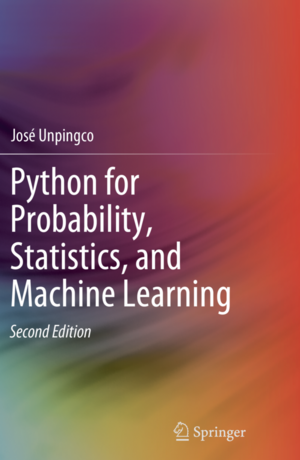

In [1]:
from IPython.display import Image
Image('../../Python_probability_statistics_machine_learning_2E.png',width=200)

In [2]:
%matplotlib inline

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'cm'
matplotlib.rcParams['mathtext.it'] = 'cm:italic'
matplotlib.rcParams['mathtext.bf'] = 'cm:bold'
import numpy as np
from matplotlib.pylab import subplots

Neural networks have a long history going back to the 1960s, but
the recent availability of large-scale, high-quality
data and new parallel computing infrastructures have reinvigorated neural
networks in terms of size and complexity. This new reinvigoration, with many
new and complex topologies, is called *deep learning*. There have been exciting
developments in image and video processing, speech recognition, and automated
video captioning based on deep learning systems. However, this is still a very
active area of research. Fortunately, big companies with major investments in
this area have made much of their research software open source (e.g.,
Tensorflow, PyTorch), with corresponding Python-bindings. To build up our
understanding of neural networks, we begin with Rosenblatt's 1960 Perceptron.

### Perceptron Learning

<div id="ch:ml:sec:perceptron"></div>

The perceptron is the primary ancestor of the most popular deep learning
technologies (i.e., multilayer perceptron) and it is the best place to start as
it will reveal the basic mechanics and themes of more complicated neural
networks.  The job of the perceptron is to create a linear classifier that can
separate points in $\mathbb{R}^n$ between two classes.  The basic idea is that
given a set of associations:

$$
\lbrace (\mathbf{x}_0,y_0),\ldots,(\mathbf{x}_m,y_m) \rbrace
$$

 where each $\mathbf{x}\in\mathbb{R}^{n-1}$ is augmented with a
unit-entry to account for an offset term, and a set of weights $\mathbf{w}\in
\mathbb{R}^n$, compute the following as an estimate of the label $y\in \lbrace
-1,1 \rbrace$.

$$
\hat{y} = \mathbf{w}^T \mathbf{x}
$$

 Concisely, this means that we want  $\mathbf{w}$ such that

$$
\mathbf{w}^T \mathbf{x}_i \underset{C_1}{\overset{C_2}{\gtrless}} 0
$$

 where $\mathbf{x}_i$ is in class $C_2$ if
$\mathbf{x}_i^T\mathbf{w}>0$ and class $C_1$ otherwise. To determine these
weights, we apply the following learning rule:

$$
\mathbf{w}^{(k+1)} = \mathbf{w}^{(k)} - (y-\hat{y})\mathbf{x}_{i}
$$

 The output of the perceptron can be summarized as

$$
\hat{y} = \sgn(\mathbf{x}_i^T \mathbf{w})
$$

 The sign is the *activation* function of the perceptron.    With this
set up, we can write out the perceptron's output as the following:

In [3]:
import numpy as np
def yhat(x,w):
    return np.sign(np.dot(x,w))

 Let us create some fake data to play with:

In [4]:
npts = 100
X=np.random.rand(npts,2)*6-3 # random scatter in 2-d plane
labels=np.ones(X.shape[0],dtype=np.int) # labels are 0 or 1
labels[(X[:,1]<X[:,0])]=-1
X = np.c_[X,np.ones(X.shape[0])] # augment with offset term

 Note that we added a column of ones to account for the offset term.
Certainly, by our construction, this problem is linearly separable, so let us
see if the perceptron can find the boundary between the two classes. Let us 
start by initializing the weights,

In [5]:
winit = np.random.randn(3)

 and then apply the learning rule,

In [6]:
w= winit
for i,j in zip(X,labels):
    w = w - (yhat(i,w)-j)*i

 Note that we are taking a single ordered pass through the data. In
practice, we would have randomly shuffled the input data to ensure that there
is no incidental structure in the order of the data that would influence
training. Now, let us examine the accuracy of the perceptron,

In [7]:
from sklearn.metrics import accuracy_score
print(accuracy_score(labels,[yhat(i,w) for i in X]))

0.85


 We can re-run the training rule over the data to try to improve the 
accuracy. A pass through the data is called an *epoch*.

In [8]:
for i,j in zip(X,labels):
    w = w - (yhat(i,w)-j)*i

print(accuracy_score(labels,[yhat(i,w) for i in X]))

0.89


 Note that our initial weight for this epoch is the last weight from
the previous pass.  It is common to randomly shuffle the data between epochs.
More epochs will result in better accuracy in this case. 

We can re-do this entire example with `keras`. First, we define the model,

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='softsign'))
model.compile(SGD(), 'hinge')

Using TensorFlow backend.
/home/unpingco/.conda/envs/pypsml2E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/unpingco/.conda/envs/pypsml2E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/unpingco/.conda/envs/pypsml2E/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/unpingco/.c

 Note that we use the `softsign` activation instead of the `sgn` that
we used earlier because we need a differentiable activation function.  Given
the form of the weight update in perceptron learning, it is equivalent to the
`hinge` loss function. Stochastic gradient descent (`SGD`) is chosen for
updating the weights.  The `softsign` function is defined as the following:

$$
s(t) = \frac{x}{1+\vert x \vert}
$$

 We can pull it out from the `tensorflow` backend that `keras` uses as 
in the following, plotted in [Figure](#fig:deep_learning_002)

In [10]:
import tensorflow as tf
x = tf.placeholder('float')
xi = np.linspace(-10,10,100)
with tf.Session() as s:
    y_=(s.run(tf.nn.softsign(x),feed_dict={x:xi}))

<!-- dom:FIGURE: [fig-machine_learning/deep_learning_002.png, width=500 frac=.65] The `softsign` function is a smooth approximation to the `sign` function. This makes it easier to differentiate for backpropagation. <div id="fig:deep_learning_002"></div> -->
<!-- begin figure -->
<div id="fig:deep_learning_002"></div>

<p>The <code>softsign</code> function is a smooth approximation to the <code>sign</code> function. This makes it easier to differentiate for backpropagation.</p>
<img src="fig-machine_learning/deep_learning_002.png" width=500>

<!-- end figure -->

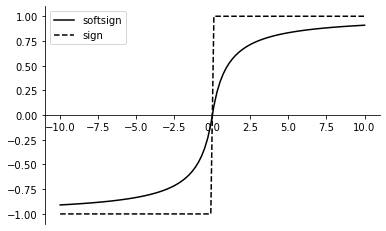

In [11]:
from matplotlib.pylab import subplots
fig,ax=subplots()
_=ax.plot(xi,y_,label='softsign',color='k')
_=ax.plot(xi,np.sign(xi),label='sign',linestyle='--',color='k')
_=ax.spines['top'].set_visible(False)
_=ax.spines['right'].set_visible(False)
_=ax.spines['bottom'].set_position(('data',0))
_=ax.legend()
fig.savefig('fig-machine_learning/deep_learning_002.png')

 Next, all we have to do is `fit` the model on data,

In [12]:
h=model.fit(X[:,:2], labels, epochs=300, verbose=0)

W0827 13:25:04.517766 140166438127424 deprecation.py:323] From /home/unpingco/.conda/envs/pypsml2E/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0827 13:25:04.543447 140166438127424 deprecation_wrapper.py:119] From /home/unpingco/.conda/envs/pypsml2E/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0827 13:25:04.555888 140166438127424 deprecation_wrapper.py:119] From /home/unpingco/.conda/envs/pypsml2E/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



 The `h` variable is the *history* that contains the internal 
metrics and parameters involved in the `fit` training phase. We can extract the 
trajectory of the loss function from this history and draw the `loss` in 
[Figure](#fig:deep_learning_003).

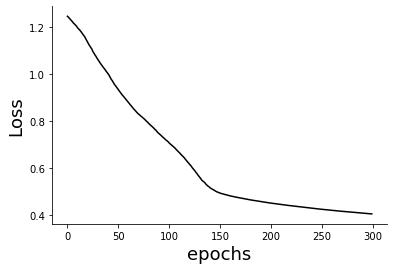

In [13]:
fig,ax=subplots()
_=ax.plot(h.history['loss'],'k-')
_=ax.set_ylabel('Loss',fontsize=18)
_=ax.set_xlabel('epochs',fontsize=18)
_=ax.spines['top'].set_visible(False)
_=ax.spines['right'].set_visible(False)
fig.savefig('fig-machine_learning/deep_learning_003.png')

<!-- dom:FIGURE: [fig-machine_learning/deep_learning_003.png, width=500 frac=.65] Trajectory of the loss function. <div id="fig:deep_learning_003"></div> -->
<!-- begin figure -->
<div id="fig:deep_learning_003"></div>

<p>Trajectory of the loss function.</p>
<img src="fig-machine_learning/deep_learning_003.png" width=500>

<!-- end figure -->


<!-- # discuss limitations for perceptron for xor problem and VC dimension comments -->

### Multi-Layer Perceptron

The Multi-Layer Perceptron (MLP) generalizes the perceptron by stacking them as
fully connected individual layers.  The basic topology is shown in [Figure](#fig:MLP_figure).  In the previous section we saw that the basic perceptron
could generate a linear boundary for data that is linearly separable. The MLP
can create more complex nonlinear boundaries. Let us examine the *moons*
dataset from scikit-learn,

<!-- dom:FIGURE: [fig-machine_learning/MLP.png, width=500 frac=.85] The basic multi-layer perceptron has a single hidden layer between input and output. Each of the arrows has a multiplicative weight associated with it.  <div id="fig:MLP_figure"></div> -->
<!-- begin figure -->
<div id="fig:MLP_figure"></div>

<p>The basic multi-layer perceptron has a single hidden layer between input and output. Each of the arrows has a multiplicative weight associated with it.</p>
<img src="fig-machine_learning/MLP.png" width=500>

<!-- end figure -->

In [14]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.1, random_state=1234)

 The purpose of the `noise` term is to make data for each of the
categories harder to disambiguate. These data are shown in [Figure](#fig:deep_learning_004)

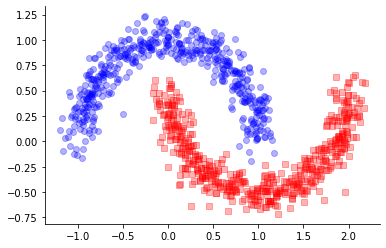

In [15]:
fig,ax=subplots()
_=ax.plot(X[y==0,0],X[y==0,1],'o',color='b',alpha=0.3)
_=ax.plot(X[y==1,0],X[y==1,1],'s',color='r',alpha=0.3)
_=ax.spines['top'].set_visible(False)
_=ax.spines['right'].set_visible(False)
fig.savefig('fig-machine_learning/deep_learning_004.png')

<!-- dom:FIGURE: [fig-machine_learning/deep_learning_004.png, width=500 frac=.65] Data from `make_moons`. <div id="fig:deep_learning_004"></div> -->
<!-- begin figure -->
<div id="fig:deep_learning_004"></div>

<p>Data from <code>make_moons</code>.</p>
<img src="fig-machine_learning/deep_learning_004.png" width=500>

<!-- end figure -->


The challenge for the MLP is to derive a nonlinear boundary between these two
classes. We contruct our MLP using `keras`,

In [16]:
from keras.optimizers import Adam
model = Sequential()
model.add(Dense(4,input_shape=(2,),activation='sigmoid'))
model.add(Dense(2,activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(Adam(lr=0.05), 'binary_crossentropy')

 This MLP has three layers. The input layer has four units and the
next layer has two units and the output layer has one unit to distinguish
between the two available classes. Instead of plain stochastic gradient
descent, we use the more advanced `Adam`  optimizer.  A quick 
summary of the model elements and parameters comes 
from the `model.summary()` method,

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


 As usual,  we split the input data into train and test sets,

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=0.3,
                                               random_state=1234)

 Thus, we reserve 30 percent of the data for testing. Next, we train the 
MLP,

In [19]:
h=model.fit(X_train, y_train, epochs=100, verbose=0)

 To compute the accuracy metric using the test set, we need to compute 
the model prediction on the this set.

In [20]:
y_train_ = model.predict_classes(X_train,verbose=0)
y_test_ = model.predict_classes(X_test,verbose=0)
print(accuracy_score(y_train,y_train_))
print(accuracy_score(y_test,y_test_))

0.9085714285714286
0.8733333333333333


  To visualize the so-derived boundary between these two classes, we
use the `contourf` function from matplotlib which generates a filled contour
plot shown in [Figure](#fig:deep_learning_005).

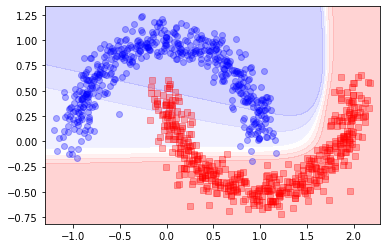

In [21]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
xticks = np.linspace(xmin-0.1, xmax+0.1, 150)
yticks = np.linspace(ymin-0.1, ymax+0.1, 150)
xg,yg = np.meshgrid(xticks, yticks)
cg = model.predict(np.c_[xg.ravel(), yg.ravel()]).reshape(xg.shape)
fig,ax=subplots()
_=ax.plot(X[y==0,0],X[y==0,1],'o',color='b',alpha=0.3)
_=ax.plot(X[y==1,0],X[y==1,1],'s',color='r',alpha=0.3)
_=ax.contourf(xg,yg, cg, cmap='bwr', alpha=0.2)
fig.savefig('fig-machine_learning/deep_learning_005.png')

<!-- dom:FIGURE: [fig-machine_learning/deep_learning_005.png, width=500 frac=.65] The derived boundary separates the two classes. <div id="fig:deep_learning_005"></div> -->
<!-- begin figure -->
<div id="fig:deep_learning_005"></div>

<p>The derived boundary separates the two classes.</p>
<img src="fig-machine_learning/deep_learning_005.png" width=500>

<!-- end figure -->


 Instead of computing the accuracy separately, we can assign it as a
*metric* for `keras` to track by supplying it on the `compile` step, as in the 
following,

In [22]:
model.compile(Adam(lr=0.05), 
              'binary_crossentropy',
              metrics=['accuracy'])

 Then, we can train again,

In [23]:
h=model.fit(X_train, y_train, epochs=100, verbose=0)

 Now, we can evaluate the model on the test data,

In [24]:
loss,acc=model.evaluate(X_test,y_test,verbose=0)
print(acc)

0.9966666666666667


 where `loss` is the loss function and `acc` is the corresponding
accuracy. The documentation has other metrics that can be specified during the
`compile` step.

### Backpropagation

We have seen that the MLP can generate complicated nonlinear boundaries for
classification problems.  The key algorithm underpinning MLP is
backpropagation. The idea is that when we stack layers into the MLP, we are 
applying function composition, which basically means we take the output of 
one function and then feed it into the input of another.

$$
h = (f \circ g)(x) = f(g(x))
$$

 For example, for the simple perceptron, we have $g(\mathbf{x}) =
\mathbf{w}^T \mathbf{x}$ and $f(x) = \sgn(x)$.  They key property of this
composition is that derivatives use the chain rule from calculus.

$$
h'(x) = f'(g(x))g'(x)
$$

 Notice this has turned the differentiation operation into a
multiplication operation. Explaining backpropagation in general is a notational
nightmare, so let us see if we can get the main idea from a specific example.
Consider the following two layer MLP with one input and one output.

There is only one input ($x_1$). The output of the first layer is

$$
z_1 = f(x_1 w_1 + b_1) = f(p_1)
$$

 where $f$ is the sigmoid function and $b_1$ is the bias term. The
output of the second layer is

$$
z_2 = f( z_1 w_2 + b_2 ) = f(p_2)
$$

 To keep it simple, let us suppose that the loss function for this MLP
is the squared error,

$$
J = \frac{1}{2}(z_2-y)^2
$$

 where $y$ is the target label. Backpropagation has two phases. The
forward phase computes the MLP loss function given the values of the inputs
and corresponding weights. The backward phase applies the incremental
weight updates to each weight based on the forward phase. To implement gradient
descent, we have to calculate the derivative of the loss function with respect
to each of the weights.

$$
\frac{\partial J}{\partial w_2} = \frac{\partial J}{\partial z_2} \frac{\partial z_2}{\partial p_2} \frac{\partial p_2}{\partial w_2 }
$$

 The first term is the following,

$$
\frac{\partial J}{\partial z_2} = z_2-y
$$

 The second term is the following,

$$
\frac{\partial z_2}{\partial p_2}  = f'(p_2) = f(p_2)(1-f(p_2))
$$

 Note that by property of the sigmoid function, we have $f'(x) =
(1-f(x))f(x)$. The third term is the following,

$$
\frac{\partial p_2}{\partial w_2}  = z_1
$$

 Thus, the update for $w_2$ is the following,

$$
\Delta w_2 \propto  (z_2-y)z_1(1-z_2) z_2
$$

 The corresponding analysis fo $b_2$ gives the following,

$$
\Delta b_2  = (z_2-y)z_2(1-z_2)
$$

Let's keep going backwards to $w_1$,

$$
\frac{\partial J}{\partial w_1}=\frac{\partial J}{\partial z_2}\frac{\partial z_2}{\partial p_2} \frac{\partial p_2}{\partial z_1 } \frac{\partial z_1}{\partial p_1 } \frac{\partial p_1}{\partial w_1 }
$$

 The first new term is the following,

$$
\frac{\partial p_2}{\partial z_1} = w_2
$$

 and then the next two terms,

$$
\frac{\partial z_1}{\partial p_1} = f(p_1)(1-f(p_1)) = z_1(1-z_1)
$$

$$
\frac{\partial p_1}{\partial w_1} = x_1
$$

 This makes the update for $w_1$,

$$
\Delta w_1 \propto (z_2-y)z_2(1-z_2)w_2 z_1(1-z_1)x_1
$$

 To understand why this is called backpropagation, we can define

$$
\delta_2 := (z_2-y)z_2(1-z_2)
$$

 This makes the weight update for $w_2$,

$$
\Delta w_2 \propto \delta_2 z_1
$$

 This means that the weight update for $w_2$ is proportional to the
output of the prior layer ($z_1$) and a factor that accounts steepness of the
activation function.  Likewise,  the weight update for $w_1$ can be written as
the following,

$$
\Delta w_1 \propto \delta_1 x_1
$$

 where

$$
\delta_1 := \delta_2 w_2 z_1(1-z_1)
$$

 Note that this weight update is proportional to the input (prior
layer's output) just as the weight update for $w_2$ was proportional to the
prior layer output $z_1$.  Also, the $\delta$ factors propagate recursively
backwards to the input layer.  These characteristics permit efficient numerical
implementations for large networks because the subsequent computations are
based on prior calculations. This also means that each individual unit's
calculations are localized upon the output of the prior layer. This helps
segregate the individual processing behavior of each unit within each layer.

### Functional Deep Learning

Keras has an alternative API that makes it possible to 
understand the performance of neural networks using the composition of 
functions ideas we discussed. The key objects for this functional 
interpretation are the `Input` object and the `Model` object.

In [25]:
from keras.layers import Input
from keras.models import Model
import keras.backend as K

 We can re-create the data from our earlier classification example

In [26]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.1, random_state=1234)

 The first step is contruct a placeholder for the input using 
the `Input` object,

In [27]:
inputs = Input(shape=(2,))

 Next, we can stack the `Dense` layers as before but now tie their 
inputs to the previous layer's outputs by calling `Dense` as a function.

In [28]:
l1=Dense(3,input_shape=(2,),activation='sigmoid')(inputs)
l2=Dense(2,input_shape=(3,),activation='sigmoid')(l1)
outputs=Dense(1,input_shape=(3,),activation='sigmoid')(l1)

 This means that $\texttt{output}=(\ell_2 \circ \ell_1 )(\texttt{input})$
where $\ell_1$ and $\ell_2$ are the middle layers. With that established, we
collect the individual pieces in the the `Model` object and then `fit` and
`train` as usual.

In [29]:
model = Model(inputs=inputs,outputs=outputs)
model.compile(Adam(lr=0.05), 
              'binary_crossentropy',
              metrics=['accuracy'])
h=model.fit(X_train, y_train, epochs=500, verbose=0)

 This gives the same result as before. The advantage of the functional
perspective is that now we can think of the individual layers as mappings
between multi-dimensional $\mathbb{R}^n$ spaces. For example, $\ell_1:
\mathbb{R}^2 \mapsto \mathbb{R}^3$ and $\ell_2: \mathbb{R}^3 \mapsto
\mathbb{R}^2$. Now, we can investigate the performance of the network 
from the inputs just up until the final mapping to $\mathbb{R}$ at the output
by defining the functional mapping $(\ell_2 \circ \ell_1)(\texttt{inputs}): \mathbb{R}^2\mapsto \mathbb{R}^2$,
as shown in [Figure](#fig:deep_learning_006).

To get this result, we have to define a keras `function` using the `inputs`.

In [30]:
l2_function = K.function([inputs], [l2])
# functional mapping just before output layer
l2o=l2_function([X_train])

 the `l2o` list contains the output of the `l2` layer that 
is shown in [Figure](#fig:deep_learning_006).

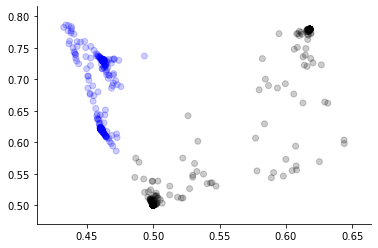

In [31]:
l2_function = K.function([inputs], [l2])
# functional mapping just before output layer
l2o=l2_function([X_train])[0]

fig,ax=subplots()
_=ax.scatter(l2o[:,0],l2o[:,1],c=[ 'b' if i else 'k' for i in y_train],alpha=0.2)
_=ax.spines['top'].set_visible(False)
_=ax.spines['right'].set_visible(False)
fig.savefig('fig-machine_learning/deep_learning_006.png')

<!-- dom:FIGURE: [fig-machine_learning/deep_learning_006.png, width=500 frac=.65] The embedded representation of the input just before the final output that shows the internal divergence of the two target classes. <div id="fig:deep_learning_006"></div> -->
<!-- begin figure -->
<div id="fig:deep_learning_006"></div>

<p>The embedded representation of the input just before the final output that shows the internal divergence of the two target classes.</p>
<img src="fig-machine_learning/deep_learning_006.png" width=500>

<!-- end figure -->


<!-- # -->

## Introduction to Tensorflow

<!-- TODO: Tensorboard intro -->



Tensorflow is the leading deep learning framework.  It is
written in $\verb!C++!$ with Python bindings. Although we
will primarily use the brilliant Keras abstraction layer to
compose our neural networks with Tensorflow providing the
backed computing, it is helpful to see how Tensorflow itself
works and how to interact with it, especially for later
debugging.  To get started, import Tensorflow using the
recommended convention.

In [32]:
import tensorflow as tf

Tensorflow is graph-based. We have to assemble a computational graph.
To get started, let's define some constants,

In [33]:
# declare constants
a = tf.constant(2)
b = tf.constant(3)

 The context manager (i.e., the `with` statement) is the recommended
way to create a *session* variable, which is a realization of the computational
graph that is composed of operations and *tensor* data objects. In this
context, a *tensor* is another word for a multidimensional matrix.

In [34]:
# default graph using the context manager
with tf.Session() as sess:
    print('a= ',a.eval())
    print('b= ',b.eval())
    print("a+b",sess.run(a+b))

a=  2
b=  3
a+b 5


 Thus, we can do some basic arithmetic on the declared variables. We
can abstract the graph using placeholders. For example, to implement the
computational graph shown in [Figure](#fig:intro_tensorflow_001), we can
define the following,

<!-- dom:FIGURE: [fig-machine_learning/adder.png, frac=0.35] Flow diagram for adder. <div id="fig:intro_tensorflow_001"></div> -->
<!-- begin figure -->
<div id="fig:intro_tensorflow_001"></div>

<p>Flow diagram for adder.</p>
<img src="fig-machine_learning/adder.png" >

<!-- end figure -->

In [35]:
a = tf.placeholder(tf.int16)
b = tf.placeholder(tf.int16)

 Next, we define the addition operation in the graph,

In [36]:
# declare operation
adder = tf.add(a,b)

 Then, we compose and execute the graph using the context manager,

In [37]:
# default graph using context manager
with tf.Session() as sess:
    print (sess.run(adder, feed_dict={a: 2, b: 3}))

5


 This works with matrices also, with few changes

In [38]:
import numpy as np
a = tf.placeholder('float',[3,5])
b = tf.placeholder('float',[3,5])
adder = tf.add(a,b)
with tf.Session() as sess:
   b_ = np.arange(15).reshape((3,5))
   print(sess.run(adder,feed_dict={a:np.ones((3,5)),
                                   b:b_}))

[[ 1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10.]
 [11. 12. 13. 14. 15.]]


 Matrix operations like multiplication are
also implemented, 

<!-- dom:FIGURE: [fig-machine_learning/multiplier.png, frac=0.35] Flow diagram for multiplier   <div id="fig:intro_tensorflow_002"></div> -->
<!-- begin figure -->
<div id="fig:intro_tensorflow_002"></div>

<p>Flow diagram for multiplier</p>
<img src="fig-machine_learning/multiplier.png" >

<!-- end figure -->

In [39]:
# the None dimension leaves it variable
b = tf.placeholder('float',[5,None])
multiplier = tf.matmul(a,b)
with tf.Session() as sess:
   b_ = np.arange(20).reshape((5,4))
   print(sess.run(multiplier,feed_dict={a:np.ones((3,5)),
                                        b:b_}))

[[40. 45. 50. 55.]
 [40. 45. 50. 55.]
 [40. 45. 50. 55.]]


 The individual computational graphs can be stacked
as shown in [Figure](#fig:intro_tensorflow_003).

<!-- dom:FIGURE: [fig-machine_learning/add_mult.png, frac=0.5] Flow diagram for adder and multiplier. <div id="fig:intro_tensorflow_003"></div> -->
<!-- begin figure -->
<div id="fig:intro_tensorflow_003"></div>

<p>Flow diagram for adder and multiplier.</p>
<img src="fig-machine_learning/add_mult.png" >

<!-- end figure -->

In [40]:
b = tf.placeholder('float',[3,5])
c = tf.placeholder('float',[5,None])
adder = tf.add(a,b)
multiplier = tf.matmul(adder,c)
with tf.Session() as sess:
   b_ = np.arange(15).reshape((3,-1))
   c_ = np.arange(20).reshape((5,4))
   print(sess.run(multiplier,feed_dict={a:np.ones((3,5)),
                                        b:b_,
                                        c:c_}))

[[160. 175. 190. 205.]
 [360. 400. 440. 480.]
 [560. 625. 690. 755.]]


### Optimizers

To compute the parameters of complicated neural networks, a wide variety of
optimization algorithms are also implemented in Tensorflow.  Consider the
classic least-squares problem: Find $\mathbf{x}$ that minimizes

$$
\min_{\mathbf{x}}\Vert\mathbf{A}\mathbf{x}-\mathbf{b}\Vert^2
$$

 First, we have to define a *variable* that we want
the optimizer to solve for,

In [41]:
x = tf.Variable(tf.zeros((3,1)))

 Next, we create sample matrices $\mathbf{A}$ and $\mathbf{b}$,

In [42]:
A = tf.constant([6,6,4,
                 3,4,0,
                 7,2,2,
                 0,2,1,
                 1,6,3],'float',shape=(5,3))
b = tf.constant([1,2,3,4,5],'float',shape=(5,1))

 In neural network terminology, the output of the model ($\mathbf{A}\mathbf{x}$)
is called the *activation*,

In [43]:
activation = tf.matmul(A,x)

 The job of the optimizer is to minimize the squared distance between
the activation and the $\mathbf{b}$ vector. Tensorflow implements primitives
like `reduce_sum` to compute the square difference as a `cost` variable.

In [44]:
cost = tf.reduce_sum(tf.pow(activation-b,2))

 With all that defined, we can construct the specific
Tensorflow optimizer we want,

In [45]:
learning_rate = 0.001
optimizer=tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

 The `learning_rate` is an embedded parameter for the
`GradientDescentOptimizer` gradient descent algorithm. Next, we
have to initialize all the variables,

In [46]:
init=tf.global_variables_initializer()

 and create the session, without the context manager, just to
show that the context manager is not a requirement,

In [47]:
sess = tf.Session()
sess.run(init)
costs=[]
for i in range(500):
   costs.append(sess.run(cost))
   sess.run(optimizer)

 Note that we have to iterate over the `optimizer` to get it to
step-wise work through the gradient descent algorithm. As an illustration, we
can plot the change in the cost function as it iterates,

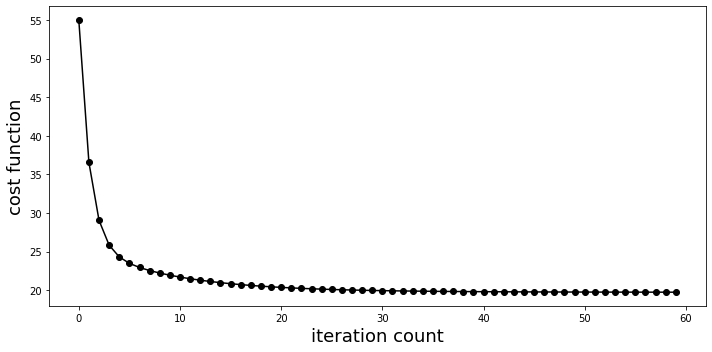

In [48]:
from matplotlib.pylab import subplots
fig,ax=subplots()
fig.set_size_inches((10,5))
_=ax.plot(costs[:60],'ok-',label='cost')
_=ax.set_xlabel('iteration count',fontsize=18)
_=ax.set_ylabel('cost function',fontsize=18)
_=fig.tight_layout()
fig.savefig('fig-machine_learning/LS_cost.png')

<!-- dom:FIGURE: [fig-machine_learning/LS_cost.png, frac=0.95] Iterative costs as gradient descent algorithm computes solution. Note that we are showing only a slice of all the values computed.  <div id="fig:intro_tensorflow_004"></div> -->
<!-- begin figure -->
<div id="fig:intro_tensorflow_004"></div>

<p>Iterative costs as gradient descent algorithm computes solution. Note that we are showing only a slice of all the values computed.</p>
<img src="fig-machine_learning/LS_cost.png" >

<!-- end figure -->


 The final answer after all the iterations is the
following,

In [49]:
print (x.eval(session=sess))

[[-0.08000698]
 [ 0.6133011 ]
 [ 0.09500197]]


 Because this is a classic problem, 
we know how to solve it analytically as in the following,

In [50]:
# least squares solution
A_=np.matrix(A.eval(session=sess))
print (np.linalg.inv(A_.T*A_)*(A_.T)*b.eval(session=sess))

[[-0.07974136]
 [ 0.6141343 ]
 [ 0.09303147]]


 which is pretty close to what we found by iterating.

### Logistic Regression with Tensorflow

As an example, let us revisit the logistic regression problem using Tensorflow.

In [51]:
import numpy as np
from matplotlib.pylab import subplots
v = 0.9
@np.vectorize
def gen_y(x):
    if x<5: return np.random.choice([0,1],p=[v,1-v]) 
    else:   return np.random.choice([0,1],p=[1-v,v])

xi = np.sort(np.random.rand(500)*10)
yi = gen_y(xi)

In [52]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
_=lr.fit(np.c_[xi],yi)

/home/unpingco/.conda/envs/pypsml2E/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The simplest multi-layer perceptron has a single hidden layer. Given the
training set $\lbrace \mathbf{x}_i,y_i \rbrace$  The input vector
$\mathbf{x}_i$ is component-wise multiplied by the *weight* vector,
$\mathbf{w}$  and then fed into the non-linear sigmoidal function.  The output
of the sigmoidal function is then compared to the training output, $y_i$,
corresponding to the weight vector, to form the error.  The key step after
error-formation is the back-propagation step. This applies the chain-rule from
calculus to transmit the differential error back to the weight vector.

Let's see if we can reproduce the logistic regression solution shown in [Figure](#fig:logreg_002) using Tensorflow. The first step is to
import the Tensorflow module,

In [53]:
import tensorflow as tf

 We need to reformat the training set slightly,

In [54]:
yi[yi==0]=-1 # use 1/-1 mapping

 Then, we create the computational graph by creating variables and
placeholders for the individual terms,

In [55]:
w = tf.Variable([0.1])
b = tf.Variable([0.1])
# the training set items fill these
x = tf.placeholder("float", [None]) 
y = tf.placeholder("float", [None])

 The output of the neural network is sometimes called the *activation*,

In [56]:
activation = tf.exp(w*x + b)/(1+tf.exp(w*x + b))

 The optimization problem is to reduce the following objective
function, which includes the one-dimensional regularization term $w^2$,

In [57]:
# objective
obj=tf.reduce_sum(tf.log(1+tf.exp(-y*(b+w*x))))+tf.pow(w,2)

 Given the objective function, we
choose the `GradientDescentOptimizer` as the optimization
algorithm with the embedded learning rate,

In [58]:
optimizer = tf.train.GradientDescentOptimizer(0.001/5.).minimize(obj)

 Now, we are just about ready to start the session. But, first we need
to initialize all the variables,

In [59]:
init=tf.global_variables_initializer()

We'll use an interactive session for convenience and then
step through the optimization algorithm in the following loop,

In [60]:
s = tf.InteractiveSession()
s.run(init)
for i in range(1000):
   s.run(optimizer,feed_dict={x:xi,y:yi})

The result of this is shown in [Figure](#fig:deep_learning_001) which
says that logistic regression and this simple single-layer
perceptron both come up with the same answer.

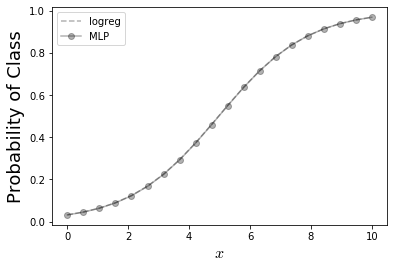

In [61]:
fig,ax=subplots()
t = np.linspace(0,10,20)
_=ax.plot(t,lr.predict_proba(np.c_[t])[:,1],label='logreg',linestyle='--',color='k',alpha=0.3)
_=ax.plot(t,s.run(activation,feed_dict={x:t}),'-ko',label='MLP',alpha=0.3)
_=ax.legend(loc=0)
_=ax.set_xlabel('$x$',fontsize=16)
_=ax.set_ylabel('Probability of Class',fontsize=18)
fig.savefig('fig-machine_learning/deep_learning_001.png')

<!-- dom:FIGURE: [fig-machine_learning/deep_learning_001.png, width=500 frac=.75] This shows the result from logistic regression as compared to the corresponding result from simple single-layer perceptron. <div id="fig:deep_learning_001"></div> -->
<!-- begin figure -->
<div id="fig:deep_learning_001"></div>

<p>This shows the result from logistic regression as compared to the corresponding result from simple single-layer perceptron.</p>
<img src="fig-machine_learning/deep_learning_001.png" width=500>

<!-- end figure -->




## Understanding Gradient Descent


<!-- TODO: mention tensorflow gradient descent algorithms -->


Consider a smooth function $f$ over $\mathbb{R}^n$ suppose we want to find
the minimum value of $f(\mathbf{x})$ over this domain, as in the following,

$$
\mathbf{x}^* = \argmin_{\mathbf{x}} f(\mathbf{x})
$$

 The idea with gradient descent is to choose an initial point
$\mathbf{x}^{(0)}\in \mathbb{R}^n$

$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - \alpha \nabla f(\mathbf{x}^{(k)})
$$

 where $\alpha$ is the step size (learning rate). The intuition here
is that $\nabla f$ is the direction of increase and so that moving in the
opposite direction scaled by $\alpha$ moves towards a lower function value.
This approach turns out to be very fast for well-conditioned, strongly convex
$f$ but in general there are practical issues.

[Figure](#fig:gradient_descent_001) shows the function $f(x) = 2 - 3 x^3 +
x^4$ and its first-order Taylor series approximation at a selected points along
the curve for a given width parameter. That is, the Taylor approximation
approximates the function at a specific point with a corresponding interval
around that point for which the approximation is assumed valid. The size of
this width is determined by the $\alpha$ step parameter. Crucially, the quality
of the approximation varies along the curve.  In particular, there are sections
where two nearby approximations overlap given the width, as indicated by the
dark shaded regions.  This is key because gradient descent works by using such
first-order approximations to estimate the next step in the minimization. That
is, the gradient descent algorithm never actually *sees* $f(x)$, but rather
only the given first-order approximant. It judges the direction of the next
iterative step by sliding down the slope of the approximant to the edge of a
region (determined by $\alpha$) and then using that next point for the next
calculated approximant. As shown by the shaded regions, it is possible that the
algorithm will overshoot the minimum because the step size ($\alpha$) is too
large. This can cause oscillations as shown in [Figure](#fig:gradient_descent_002).

In [62]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'cm'
matplotlib.rcParams['mathtext.it'] = 'cm:italic'
matplotlib.rcParams['mathtext.bf'] = 'cm:bold'
import numpy as np
from matplotlib.pylab import subplots

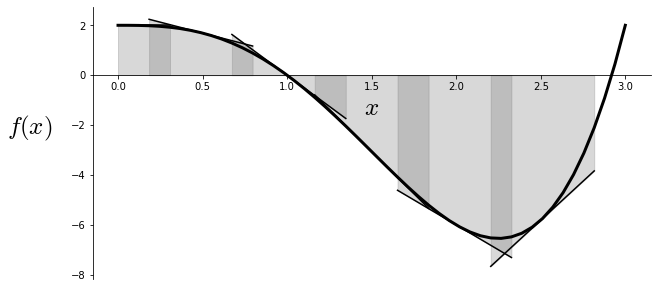

In [63]:

xi=np.linspace(0,3,50)

def get_chunk(x_0=1,delta=0.1,n=2):
    '''
    n := order of approximation
    '''
    x_0 = float(x_0)
    delta = float(delta)
    return fx.series(x,x0=sm.var('x0'),n=n).removeO().subs(x0,x_0),(x_0-delta<=x)&(x<x_0+delta)

def get_pw(x0list,delta = 0.1):
    pw=sm.lambdify(x,sm.Piecewise(*[get_chunk(float(i),delta) for i in x0list]))
    x0 = np.array(x0list)
    edges = np.vstack([x0-delta,x0+delta]).T
    return pw,edges

import sympy as sm 
x = sm.var('x')
fx = 2 - 3*x**3 + x**4
fxx = sm.lambdify(x,fx)
pw,edges = get_pw(np.arange(0,3,0.5),.5/2.)

fig,ax= subplots()
fig.set_size_inches((10,5))
funcs= [sm.lambdify(x,sm.Piecewise(get_chunk(i,0.35))) for i in edges.mean(axis=1)]

_=ax.plot(xi,fxx(xi),lw=3,color='k')
_=ax.set_ylabel(r'$f(x)$'+' '*10,fontsize=25,rotation=0)
_=ax.set_xlabel(r'$x$',fontsize=25,rotation=0)
_=ax.spines['top'].set_visible(False)
_=ax.spines['right'].set_visible(False)
_=ax.spines['bottom'].set_position(('data',0))

for i in funcs:
    _=ax.fill_between(xi,i(xi),color='gray',alpha=0.3)
    _=ax.plot(xi,i(xi),color='k')

fig.savefig('fig-machine_learning/gradient_descent_001.png')

<!-- dom:FIGURE: [fig-machine_learning/gradient_descent_001.png, width=500 frac=0.85] The piecewise linear approximant to $f(x)$. <div id="fig:gradient_descent_001"></div>  -->
<!-- begin figure -->
<div id="fig:gradient_descent_001"></div>

<p>The piecewise linear approximant to $f(x)$.</p>
<img src="fig-machine_learning/gradient_descent_001.png" width=500>

<!-- end figure -->


<!-- # ** -->

Let us consider the following Python implementation of gradient descent, using Sympy.

In [64]:
x = sm.var('x')
fx = 2 - 3*x**3 + x**4
df = fx.diff(x) # compute derivative
x0 =.1 # initial guess
xlist = [(x0,fx.subs(x,x0))]
alpha = 0.1 # step size
for i in range(20):
    x0 = x0 - alpha*df.subs(x,x0)
    xlist.append((x0,fx.subs(x,x0)))

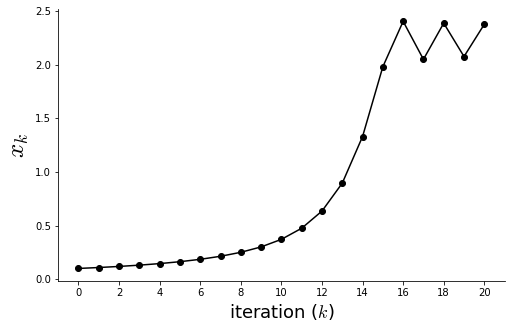

In [65]:
xlist = np.array(xlist).astype(float)
fig,ax= subplots()
fig.set_size_inches((8,5))
_=ax.plot(xlist[:,0],'-ok')
_=ax.set_xticks(range(0,21,2))
_=ax.set_xlabel('iteration ($k$)',fontsize=18)
_=ax.set_ylabel('$x_k$',fontsize=25)
_=ax.spines['top'].set_visible(False)
_=ax.spines['right'].set_visible(False)
fig.savefig('fig-machine_learning/gradient_descent_002.png')

 [Figure](#fig:gradient_descent_002) shows the sequential steps. Note
that the algorithm oscillates at the end because the step size is too large.
Practically speaking, it is not possible to know the optimal step size for
general functions without strong assumptions on $f(x)$.


<!-- dom:FIGURE: [fig-machine_learning/gradient_descent_002.png, width=500 frac=0.85] The step size may cause oscillations.   <div id="fig:gradient_descent_002"></div>  -->
<!-- begin figure -->
<div id="fig:gradient_descent_002"></div>

<p>The step size may cause oscillations.</p>
<img src="fig-machine_learning/gradient_descent_002.png" width=500>

<!-- end figure -->


 [Figure](#fig:gradient_descent_003) shows how the algorithm moves
along the function as well as the approximant ($\hat{f}(x)$) that the algorithm
sees along the way. Note that initial steps are crowded around the initial
point because the corresponding gradient is small there. Towards the middle,
the algorithm makes a big jump because the gradient is steep, before finally
oscillating towards the end. Sections of the underlying function that are
relatively flat can cause the algorithm to converge very slowly.  Furthermore,
if there are multiple local minima, then the algorithm cannot guarantee finding
the global minimum.

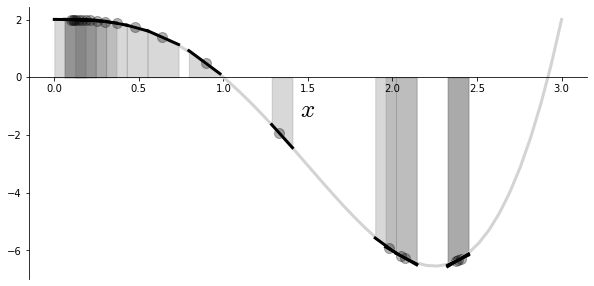

In [66]:
fig,ax= subplots()
fig.set_size_inches((10,5))
funcs= [sm.lambdify(x,sm.Piecewise(get_chunk(i,0.1))) for i in xlist[:,0]]
_=ax.plot(xlist[:,0],xlist[:,1],marker='o',ls='',markersize=10,alpha=.3,color='k',label=r'$f(x_k)$')
_=ax.plot(xi,fxx(xi),lw=3,color='lightgray',label='$f(x)$')
_=ax.set_xlabel(r'$x$',fontsize=25,rotation=0)
_=ax.spines['top'].set_visible(False)
_=ax.spines['right'].set_visible(False)
_=ax.spines['bottom'].set_position(('data',0))

for i in funcs:
    _=ax.fill_between(xi,i(xi),color='gray',alpha=0.3)
    _=ax.plot(xi,i(xi),color='k',lw=3,label=r'$\hat{f}(x)$')

fig.savefig('fig-machine_learning/gradient_descent_003.png')

<!-- dom:FIGURE: [fig-machine_learning/gradient_descent_003.png, width=600 frac=0.95] Gradient descent produces a sequence of approximants. <div id="fig:gradient_descent_003"></div>  -->
<!-- begin figure -->
<div id="fig:gradient_descent_003"></div>

<p>Gradient descent produces a sequence of approximants.</p>
<img src="fig-machine_learning/gradient_descent_003.png" width=600>

<!-- end figure -->


As we have seen, the step size is key to both performance and convergence.
Indeed, a step size that is too big can cause divergence and one that is too
small can take a very long time to converge.  

### Newton's Method

Consider the following second-order Taylor series expansion

$$
J(\mathbf{x})= f(\mathbf{x}_0) + \nabla f(\mathbf{x}_0)^T(\mathbf{x}-\mathbf{x}_0) +\frac{1}{2}(\mathbf{x}-\mathbf{x}_0)^T \nabla^2 f(\mathbf{x}_0)(\mathbf{x}-\mathbf{x}_0)
$$

 where $ \mathbf{H(x)} := \nabla^2 f(\mathbf{x})$ is the Hessian matrix
of second derivatives. The $(i,j)^{th}$ entry of this matrix is the following:

$$
\frac{\partial^2 f(\mathbf{x})}{\partial x_i \partial x_j}
$$

 We can use basic matrix calculus to find the minimum by computing:

$$
\nabla_{\mathbf{x}} J(\mathbf{x}) = \nabla f(\mathbf{x}_0) + \mathbf{H(x)}(\mathbf{x}-\mathbf{x}_0) = 0
$$

 Solving this for $\mathbf{x}$ gives the following:

$$
\mathbf{x}=\mathbf{x}_0- \mathbf{H(x)}^{-1} \nabla f(\mathbf{x}_0)
$$

 Thus, after renaming some terms, the descent algorithm works by the
following update equation:

$$
\mathbf{x}^{(k+1)}=\mathbf{x}^{(k)}- \mathbf{H}(\mathbf{x}^{(k)})^{-1} \nabla f(\mathbf{x}^{(k)})
$$

 There are a number of practical problems with this update equation.
First, it requires computing the Hessian matrix at every step. For a
significant problem, this means managing a potentially very large matrix. For
example, given 1000 dimensions the corresponding Hessian has $1000 \times 1000$
elements.  Some other issues are that the Hessian may not be numerically stable
enough to invert, the functional form of the partial derivatives may have to be
separately approximated,  and the initial guess has to be in a region where the
convexity of the function matches the derived assumption. Otherwise, just based
on these equations, the algorithm will converge on the local *maximum* and not
the local *minimum*.  Consider a slight change of the previous code to
implement Newton's method:

In [67]:
x0 =2. # init guess is near to solution
xlist = [(x0,fx.subs(x,x0))]
df2 = fx.diff(x,2) # 2nd derivative

for i in range(5):
    x0 = x0 - df.subs(x,x0)/df2.subs(x,x0)
    xlist.append((x0,fx.subs(x,x0)))
    
xlist = np.array(xlist).astype(float)
print (xlist)

[[ 2.         -6.        ]
 [ 2.33333333 -6.4691358 ]
 [ 2.25555556 -6.54265522]
 [ 2.25002723 -6.54296874]
 [ 2.25       -6.54296875]
 [ 2.25       -6.54296875]]


 Note that it took very few iterations to get to the minimum (as
compared to our prior method), but if
the initial guess is too far away from the actual minimum, the algorithm may
not find the local minimum at all and instead find the local maximum.
Naturally, there are many extensions to this method to account for these
effects, but the main thrust of this section is to illustrate how higher-order
derivatives (when available) in a computationally feasible context can greatly
accelerate convergence of descent algorithms.

### Managing Step Size

The problem of determining a good step size (learning rate) can be approached
with an *exact line search*. That is, along the ray that extends along
$\mathbf{x}+ q \nabla f(x)$, find

$$
q_{min} = \argmin_{q\ge 0} f(\mathbf{x}+q \nabla f(\mathbf{x}))
$$

 In words, this means that given a direction from a point $\mathbf{x}$
along the direction $\nabla f(\mathbf{x})$, find the minimum for this
one-dimensional problem. Thus, the minimization procedure alternates at each
iteration between moving to a new $\mathbf{x}$ position in $\mathbb{R}^n$ and
finding a new step size by solving the one-dimensional minimization.

While this is conceptually clean, the problem is that solving the
one-dimensional line-search at every step means evaluating the objective
function $f(\mathbf{x})$ at many points along the one-dimensional slice.  This
can be very time consuming for an objective function that is computationally
expensive to evaluate.  With Newton's method, we have seen that higher-order
derivatives can accelerate convergence and we can apply those ideas to the
one-dimensional line search, as with the *backtracking* algorithm.

* Fix parameters $\beta\in [0,1)$ an $\alpha>0$.

* If $f(x-\alpha\nabla f(x))> f(x)- \alpha \Vert \nabla f(x) \Vert_2^2$
  then reduce $\alpha\rightarrow \beta \alpha$. Otherwise, do the usual 
  gradient descent update: $x^{(k+1)}= x^{(k)}-\alpha\nabla f(x^{(k)})$.

 To gain some intuition about how this works, return to our second-order 
Taylor series expansion of the function $f$ about $\mathbf{x}_0$,

$$
f(\mathbf{x}_0)+\nabla f(\mathbf{x}_0)^T(\mathbf{x}-\mathbf{x}_0)+\frac{1}{2}(\mathbf{x}-\mathbf{x}_0)^T \nabla^2 f(\mathbf{x}_0)(\mathbf{x}-\mathbf{x}_0)
$$

 We have already discussed the numerical issues with the Hessian term,
so one approach is to simply replace that term with an $n\times n$ identity
matrix $\mathbf{I}$ to obtain the following:

$$
h_{\alpha}(\mathbf{x})= f(\mathbf{x}_0) + \nabla f(\mathbf{x}_0)^T(\mathbf{x}-\mathbf{x}_0) +\frac{1}{2\alpha}\Vert\mathbf{x}-\mathbf{x}_0\Vert^2
$$

 This is our more tractable *surrogate* function. But what is the
relationship between this surrogate and what we are actually trying to
minimize?  The key difference is that the curvature information that is
contained in the Hessian term has now been reduced to a single $1/\alpha$
factor. Intuitively, this means that local complicated curvature of $f$ about a
given point $\mathbf{x}_0$ has been replaced with a uniform bowl-shaped
structure, the steepness of which is determined by scaling $1/\alpha$. 
Given a specific $\alpha$, we already know how to step directly to the 
minimum of $h_{\alpha}(\mathbf{x})$; namely, using the following gradient descent 
update equation:

$$
\mathbf{x}^{(k+1)}= \mathbf{x}^{(k)} - \alpha \nabla f (\mathbf{x}^{(k)})
$$

 That is the immediate solution to the surrogate problem, but it does
not directly supply the next iteration for the function we really want: $f$.
Let us suppose that our minimization of the surrogate has taken us to a new
point $\mathbf{x}^{(k)}$ that satisfies the following inequality,

$$
f(\mathbf{x}^{(k+1)}) \le h_{\alpha}(\mathbf{x}^{(k+1)})
$$

 or, more explicitly,

$$
f(\mathbf{x}^{(k+1)}) \le f(\mathbf{x}^{(k)}) + \nabla f(\mathbf{x}^{(k)})^T(\mathbf{x}^{(k+1)}-\mathbf{x}^{(k)}) +\frac{1}{2\alpha}\Vert\mathbf{x}^{(k+1)}-\mathbf{x}^{(k)}\Vert^2
$$

 We can substitute the update equation into this and simplify as,

$$
f(\mathbf{x}^{(k+1)})\le f(\mathbf{x}^{(k)}) -\alpha\nabla f(\mathbf{x}^{(k)})^T(\nabla f(\mathbf{x}^{(k)}))+\frac{\alpha}{2}\Vert\nabla f (\mathbf{x}^{(k)})\Vert^2
$$

 which ultimately boils down to the following,

<!-- Equation labels as ordinary links -->
<div id="eq:backtracking"></div>

$$
\begin{equation}
f(\mathbf{x}^{(k+1)})\le f(\mathbf{x}^{(k)})-\frac{\alpha}{2}\Vert\nabla f(\mathbf{x}^{(k)}) \Vert^2 
\label{eq:backtracking} \tag{1}
\end{equation}
$$

 The important observation here is that if we have not reached the minimum 
of $f$, then the last term is always positive and we have moved downwards,

$$
f(\mathbf{x}^{(k+1)}) < f(\mathbf{x}^{(k)})
$$

 which is what we were after. Conversely, if the inequality in
Equation ([1](#eq:backtracking)) holds for some $\alpha>0$, then we know that
$h_{\alpha}>f$. This is the key observation
behind the backtracking algorithm. That is, we can test a sequence of values
for $\alpha$ until we find one that satisfies Equation ([1](#eq:backtracking)).
For example, we can start with some initial $\alpha$ and then scale it up or
down until the inequality is satisfied which means that we have found the
correct step size and then can proceed with the descent step. This is what
the backtracking algorithm is doing as shown in [Figure](#fig:gradient_descent_004). The dotted line is the $h_{\alpha}(x)$ and the
gray line is $f(x)$. The algorithm hops to the quadratic minimum of the
$h_{\alpha}(x)$ function which is close to the actual minimum of $f(x)$.

The basic implementation of backtracking is shown below:

In [68]:
x0 = 1
alpha = 0.5
xnew = x0 - alpha*df.subs(x,x0)
while fx.subs(x,xnew)>(fx.subs(x,x0)-(alpha/2.)*(fx.subs(x,x0))**2):
    alpha = alpha * 0.8
    xnew = x0 - alpha*df.subs(x,x0)

print (alpha,xnew)

0.32000000000000006 2.60000000000000


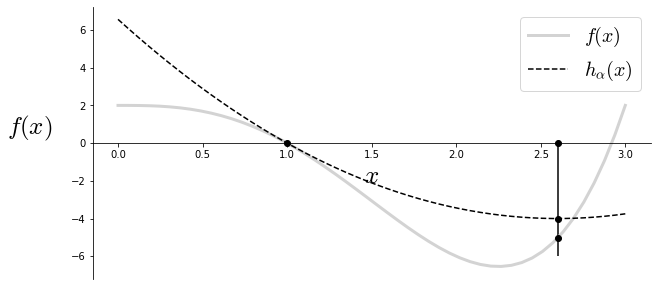

In [69]:

fig,ax= subplots()
fig.set_size_inches((10,5))
_=ax.plot(xi,fxx(xi),lw=3,color='lightgray',label='$f(x)$')
ha = fx.subs(x,x0) + df.subs(x,x0)*(x-x0)+1/(alpha*2)*(x-x0)**2
haxx = sm.lambdify(x,ha)
_=ax.plot([1],[fxx(1)],'ok')

_=ax.plot(xi,haxx(xi),'--k',label=r'$h_{\alpha}(x)$')
_=ax.plot([xnew],[fxx(xnew)],'ok')
_=ax.plot([xnew],[haxx(xnew)],'ok')
_=ax.plot([xnew],[0],'ok')

_=ax.vlines(xnew,-6,0)
_=ax.set_xlabel(r'$x$',fontsize=25,rotation=0)
_=ax.spines['top'].set_visible(False)
_=ax.spines['right'].set_visible(False)
_=ax.spines['bottom'].set_position(('data',0))
_=ax.set_ylabel(r'$f(x)$'+' '*10,fontsize=25,rotation=0);

_=ax.legend(fontsize=20)

fig.savefig('fig-machine_learning/gradient_descent_004.png')

<!-- dom:FIGURE: [fig-machine_learning/gradient_descent_004.png, width=500 frac=0.85] The approximation $h_{\alpha}(x)$ (dotted line) moves the next iteration from $x=1$ to the indicated point that is near the minimum of $f(x)$ by finding an appropriate step size ($\alpha$). <div id="fig:gradient_descent_004"></div>  -->
<!-- begin figure -->
<div id="fig:gradient_descent_004"></div>

<p>The approximation $h_{\alpha}(x)$ (dotted line) moves the next iteration from $x=1$ to the indicated point that is near the minimum of $f(x)$ by finding an appropriate step size ($\alpha$).</p>
<img src="fig-machine_learning/gradient_descent_004.png" width=500>

<!-- end figure -->


<!-- # 4.4.3.3 STOCHASTIC APPROXIMATION TO GRADIENT DESCENT Machine_learning_Mitchell -->

### Stochastic Gradient Descent

A common variation on gradient descent is to alter how the weights are updated.
Specifically, suppose we want to minimize an objective function of the
following form:

$$
\min_x \sum_{i=1}^m f_i(x)
$$

 where $i$ indexes the $i^{th}$ data element for an error function. 
Equivalently, each summand is parameterized by a data element. 

For the usual gradient descent algorithm, we would compute the
incremental weights, component-wise as in the following

$$
x^{(k+1)} = x^{(k)} -\alpha_k \sum_{i=1}^m \partial f_i(x^{(k)})
$$

 by summing over all of the data. The key idea for stochastic gradient
descent is to *not* sum over all of the data but rather to update the weights for
each randomized $i^{th}$ data element:

$$
x^{(k+1)} = x^{(k)} -\alpha_k \partial f_i(x^{(k)})
$$

 A compromise between batch and this jump-every-time stochastic
gradient descent is *mini-batch* gradient descent in which a randomized subset
($\sigma_r, \vert\sigma_r\vert=M_b$) of the data is summed over at each step as
in the following:

$$
x^{(k+1)} = x^{(k)} -\alpha_k \sum_{i\in \sigma_r} \partial f_i(x^{(k)})
$$

 Each step update for the standard gradient descent algorithm
processes $m$ data points for each of the $p$ dimensions, $\mathcal{O}(mp)$,
whereas for stochastic gradient descent, we have $\mathcal{O}(p)$. Mini-batch
gradient descent is somewhere in-between these estimates. For very large,
high-dimensional data, the computational costs of gradient descent can become
prohibitive thus favoring stochastic gradient descent.  Outside of the
computational advantages, stochastic gradient descent has other favorable
attributes. For example, the noisy jumping around helps the algorithm avoid
getting stalled in local minima and this helps the algorithm when the starting
point is far away from the actual minimum. The obverse is that stochastic
gradient descent can struggle to clinch the minimum when it is close to it.
Another advantage is robustness to a minority of *bad* data elements.  Because
only random subsets of the data are actually used in the update, the few
individual outlier data points (perhaps due to poor data integrity) do not
necessarily contaminate every step update.

### Momentum

The gradient descent algorithm can be considered as a particle moving along a
high-dimensional landscape in search of a minimum. Using a physical analogy, we
can add the concept of momentum to the particle's motion.  Consider the
position of the particle ($\mathbf{x}^{(k)}$) at any time $k$ under a net force
proportional to $-\nabla J$. This setup induces an estimated velocity term for
the particle motion proportional to  $\eta (\mathbf{x}^{(k+1)} -
\mathbf{x}^{(k)}) $.  That is, the particle's velocity is estimated
proportional to the difference in two successive positions. The 
simplest version of stochastic gradient descent update that incorporates
this momentum is the following:

$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - \alpha \nabla f(\mathbf{x}^{(k)}) + \eta (\mathbf{x}^{(k+1)} - \mathbf{x}^{(k)} )
$$

 Momentum is particularly useful when gradient descent sloshes up and
down  a steep ravine in the error surface instead of pursuing the descending
ravine directly to the local minimum. This oscillatory behavior can cause slow
convergence. There are many extensions to this basic idea such as Nesterov
momentum.

### Advanced Stochastic Gradient Descent

Methods that aggregate histories of the step updates can provide superior
performance to the basic stochastic gradient descent algorithm. For example,
Adam (Adaptive Moment Estimator) implements an adaptive step-size for each
parameter. It also keeps track of an exponentially decaying mean and variance
of past gradients using the exponentially weighted moving average (EWMA).  This
smoothing technique computes the following recursion,

$$
y_n  = a x_n + (1-a) y_{n-1}
$$

 with $y_0=x_0$ as the initial condition. The $0<a<1$ factor controls
the amount of mixing between the previous moving average and the new data point
at $n$. For example, if $a=0.9$, the EWMA favors the new data $x_n$ over the
prior value $y_{n-1}$ ($1-a=0.1$) of the EWMA. This calculation is common in a
wide variety of timeseries applications (i.e., signal processing, quantitative
finance). The impulse response of the EWMA ($x=\delta_n$) is $(1-a)^n$. You can
think of this as the weighted window function that is applied to $x_n$. As
opposed to the standard moving average that considers a fixed window of data to
average over, this exponential window retains prior memory of the entire
sequence, albeit weighted by powers of $(1-a)$. To see this, we can generate
the response to an impulse data series using `pandas`,

In [70]:
import pandas as pd
x = pd.Series([1]+[0]*20)
ma =x.rolling(window=3, center=False).mean()
ewma  = x.ewm(1).mean()

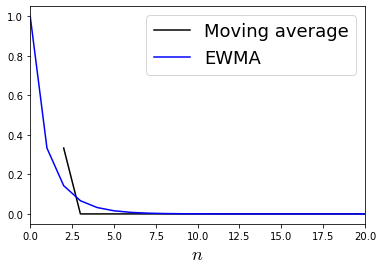

In [71]:
fig,ax= subplots()
_=ma.plot(ax=ax,label='Moving average',color='k')
_=ewma.plot(ax=ax,label='EWMA',color='b')
_=ax.legend(fontsize=18)
_=ax.set_xlabel('$n$',fontsize=18)
fig.savefig('fig-machine_learning/gradient_descent_005.png')

 As shown by [Figure](#fig:gradient_descent_006), the single nonzero
data point thereafter influences the EWMA  whereas for the fixed-width moving
window average, the effect terminates after the window passes. Note that 
mini-batch smoothes out data at each iteration by averaging over training data and 
EWMA smoothes out the descent motion across iterations of the algorithm.

<!-- dom:FIGURE: [fig-machine_learning/gradient_descent_005.png, width=500 frac=0.75] The approxmation $h_{\alpha}(x)$ (dotted line) moves the next iteration from $x=1$ to the indicated point that is near the minimum of $f(x)$ by finding an appropriate step size ($\alpha$). <div id="fig:gradient_descent_005"></div>  -->
<!-- begin figure -->
<div id="fig:gradient_descent_005"></div>

<p>The approxmation $h_{\alpha}(x)$ (dotted line) moves the next iteration from $x=1$ to the indicated point that is near the minimum of $f(x)$ by finding an appropriate step size ($\alpha$).</p>
<img src="fig-machine_learning/gradient_descent_005.png" width=500>

<!-- end figure -->


Advanced stochastic gradient descent algorithms are
themselves an area of intense interest and development. Each method has its
strengths and weaknesses pursuant to the data at hand (i.e., sparse vs. dense
data) and there is no clear favorite appropriate to all circumstances. As a
practical matter, some variants have parallel implementations that accelerate
performance (i.e., Nui's Hogwild update scheme).

### Python Example Using Sympy

Each of these methods will make more sense with some Python. We emphasize that
this implementation is strictly expository and would not be suitable for a
large-scale application.  Let us reconsider the classification problem in the
section on logistic regression with the target $y_i\in \lbrace 0,1 \rbrace$.
The logistic regression seeks to minimize the cross-entropy:

$$
J(\boldsymbol{\beta}) = \sum_i^m \log(1+\exp(\mathbf{x_i}^T \boldsymbol{\beta}))-y_i \mathbf{x_i}^T \boldsymbol{\beta}
$$

 with the corresponding gradient,

$$
\nabla_{\beta} J(\boldsymbol{\beta}) = \sum_i^m \frac{1}{1+\exp(- \mathbf{x}_i^T \boldsymbol{\beta})} \mathbf{x}_i - y_i \mathbf{x}_i
$$

 To get started let's create some sample data for logistic regression

In [72]:
import numpy as np
import sympy as sm
npts = 100
X=np.random.rand(npts,2)*6-3 # random scatter in 2-d plane
labels=np.ones(X.shape[0],dtype=np.int) # labels are 0 or 1
labels[(X[:,1]<X[:,0])]=0

 This provides the data in the `X` Numpy array and the target labels 
in the `labels` array. Next, we want to develop the objective function with Sympy,

In [73]:
x0,x1 = sm.symbols('x:2',real=True) # data placeholders
b0,b1 = sm.symbols('b:2',real=True) # parameters
bias = sm.symbols('bias',real=True) # bias term
y = sm.symbols('y',real=True) # label placeholders
summand = sm.log(1+sm.exp(x0*b0+x1*b1+bias))-y*(x0*b0+x1*b1+bias)
J = sum([summand.subs({x0:i,x1:j,y:y_i}) 
           for (i,j),y_i in zip(X,labels)])

 We can use Sympy to compute the gradient as in the following:

In [74]:
from sympy.tensor.array import derive_by_array
grad = derive_by_array(summand,(b0,b1,bias))

 Using the `sm.latex` function renders `grad` as the 
following:

$$
\left[\begin{matrix}- x_0 y+\frac{x_0 e^{b_0 x_0 + b_1 x_1 + bias}}{e^{b_0 x_0 + b_1 x_1 + bias} + 1} & - x_1 y + \frac{x_1 e^{b_0 x_0 + b_1 x_1 + bias}}{e^{b_0 x_0 + b_1 x_1 + bias} + 1} & - y + \frac{e^{b_0 x_0 + b_1 x_1 + bias}}{e^{b_0 x_0 + b_1 x_1+bias}+1}\end{matrix}\right]
$$

 which matches our previous computation of the gradient.  For standard
gradient descent, the gradient is computed by summing over all of the data,

In [75]:
grads=np.array([grad.subs({x0:i,x1:j,y:y_i}) 
                    for (i,j),y_i in zip(X,labels)]).sum(axis=0)

 Now, to implement gradient descent, we set up the following loop:

In [76]:
# convert expression into function
Jf = sm.lambdify((b0,b1,bias),J)
gradsf = sm.lambdify((b0,b1,bias),grads)
niter = 200
winit = np.random.randn(3)*20
alpha = 0.1 # learning rate (step-size)
WK = winit  # initialize 
Jout=[] # container for output
for i in range(niter):
    WK = WK - alpha * np.array(gradsf(*WK))
    Jout.append(Jf(*WK))

<!-- # ** -->

 For stochastic gradient descent, the above code changes to the following:

In [77]:
import random
sgdWK = winit  # initialize 
Jout=[] # container for output
# don't sum along all data as before
grads=np.array([grad.subs({x0:i,x1:j,y:y_i}) 
                    for (i,j),y_i in zip(X,labels)])
for i in range(niter):
    gradsf = sm.lambdify((b0,b1,bias),random.choice(grads))
    sgdWK = sgdWK - alpha * np.array(gradsf(*sgdWK))
    Jout.append(Jf(*sgdWK))

<!-- # ** -->

 The main difference here is that the gradient calculation no longer
sums across all of the input data (i.e., `grads` list) and is instead randomly
chosen by the `random.choice` function the above body of the loop. The 
extension to batch gradient descent from this code just requires 
averaging over a sub-selection of the data for the gradients in the 
`batch` variable.

In [78]:
mbsgdWK = winit  # initialize 
Jout=[] # container for output
mb = 10 # number of elements in batch
for i in range(niter):
    batch = np.vstack([random.choice(grads) 
                          for i in range(mb)]).mean(axis=0)    
    gradsf = sm.lambdify((b0,b1,bias),batch)
    mbsgdWK = mbsgdWK-alpha*np.array(gradsf(*mbsgdWK))
    Jout.append(Jf(*mbsgdWK))

 It is straight-forward to incorporate momentum into this loop using a
Python `deque`, as in the following,

<!-- # ** -->

In [79]:
from collections import deque
momentum = deque([winit,winit],2)
mbsgdWK = winit  # initialize 
Jout=[] # container for output
mb = 10 # number of elements in batch
for i in range(niter):
    batch=np.vstack([random.choice(grads) 
                       for i in range(mb)]).mean(axis=0)    
    gradsf=sm.lambdify((b0,b1,bias),batch)
    mbsgdWK=mbsgdWK-alpha*np.array(gradsf(*mbsgdWK))+0.5*(momentum[1]-momentum[0])
    Jout.append(Jf(*mbsgdWK))

<!-- # ** -->

[Figure](#fig:gradient_descent_006) shows the three variants of the gradient
descent algorithm. Notice that the stochastic gradient descent algorithm is the
most erratic, as it is characterized by taking a new direction for every
randomly selected data element. Mini-batch gradient descent smoothes these 
out by averaging across multiple data elements. The momentum variant 
is somewhere in-between the to as the effect of the momentum term is not 
pronounced in this example.

<!-- dom:FIGURE: [fig-machine_learning/gradient_descent_006.png, width=500 frac=0.85] Different variations of gradient descent. <div id="fig:gradient_descent_006"></div>  -->
<!-- begin figure -->
<div id="fig:gradient_descent_006"></div>

<p>Different variations of gradient descent.</p>
<img src="fig-machine_learning/gradient_descent_006.png" width=500>

<!-- end figure -->


### Python Example Using Theano

The code shown makes each step of the gradient descent algorithms explicit
using Sympy, but this implementation is far too slow.  The `theano` module
provides thoughtful and powerful high-level abstractions for algorithm
implementation that relies upon underlying C/C++ and GPU execution models. This
means that calculations that are prototyped with `theano` can be executed
downstream outside of the Python interpreter which makes them much faster. The 
downside of this approach is that calculations can become much harder to
debug because of the multiple levels of abstraction. Nonetheless, `theano` is 
a powerful tool for algorithm development and execution.

To get started we need some basics from `theano`.

In [80]:
import theano
import theano.tensor as T
from theano import function, shared

 the next step is to define variables, which are essentially
placeholders for values that will be computed downstream later. The next block
defines two named variables as a double-sized float matrix and vector. Note
that we did not have to specify the dimensions of each at this point.

In [81]:
x = T.dmatrix("x") # double matrix
y = T.dvector("y") # double vector

 The parameters of our implementation of gradient descent come next,
as the following:

In [82]:
w = shared(np.random.randn(2), name="w") # parameters to fit
b = shared(0.0, name="b") # bias term

 variables that are `shared` are ones whose values can be set
separately via other computations or directly via the `set_value()` method.
These values can also be retrieved using the `get_value()` method. Now, we need
to define the probability of obtaining a `1` from the given data as `p`.  The
cross-entropy function and the `T.dot` function are already present (along with
a wide range of other related functions) in `theano`.  The conformability of
the constituent arguments is the responsibility of the user.

In [83]:
p=1/(1+T.exp(-T.dot(x,w)-b)) # probability of 1
error = T.nnet.binary_crossentropy(p,y)
loss = error.mean() 
gw, gb = T.grad(loss, [w, b])

 The `error` variable is  `TensorVariable` type which has many
built-in methods such as `mean`. The so-derived `loss` function is therefore
also a `TensorVariable`. The last `T.grad` line is the best part of Theano because 
it can compute these gradients automatically.

In [84]:
train = function(inputs=[x,y],
                 outputs=[error], 
                 updates=((w, w - alpha * gw),
                          (b, b - alpha * gb)))

 The last step is to set up training by defining the training function
in `theano`. The user will supply the previously defined and named input
variables (`x` and `y`) and `theano` will return the previously defined `error`
variable. Recall that the `w` and `b` variables were defined as `shared`
variables. This means that the function `train` can update their values between
calls using the update formula specified in the `updates` keyword variable. In
this case, the update is just plain gradient descent with the previously
defined `alpha` step-size variable.

We can execute the training plain using the `train` function in the following loop:

In [85]:
training_steps=1000
for i in range(training_steps):
    error = train(X, labels)

 The `train(X,labels)` call is where the `X` and `labels` arrays we
defined earlier replace the placeholder variables. The update step refreshes
all of the `shared` variables at each iterative step. At the end of the
iteration, the so-computed parameters are in the `w` and `b` variables with
values available via `get_value()`. The implementation for stochastic gradient
descent requires just a little modification to this loop, as in the following:

In [86]:
for i in range(training_steps):
    idx = np.random.randint(0,X.shape[0])
    error = train([X[idx,:]], [labels[idx]])

 where the `idx` variable selects a random data element from the set and 
uses that for the update step at every iteration. Likewise, batch stochastic 
gradient descent follows with the following modification,

In [87]:
batch_size = 50
indices = np.arange(X.shape[0])
for i in range(training_steps):
    idx = np.random.permutation(indices)[:batch_size]
    error = train(X[idx,:], labels[idx])

print (w.get_value()) 
print (b.get_value()) # bias term

[-4.6811301   4.53544488]
-0.5143806030648878


 Here, we set up an `indices` variable that is used for randomly
selecting subsets in the `idx` variable that are passed to the `train`
function. All of these implementations parallel the corresponding previous
implementations in Sympy, but these are many orders of magnitude faster due to
`theano`.

<!-- # <https://web.archive.org/web/20140508200053/http>://brahms.cpmc.columbia.edu/publications/momentum.pdf -->

## Image Processing Using Convolutional Neural Networks

In [88]:
import numpy as np
from matplotlib.pylab import subplots, cm
def text_grid(res,i,j,t,ax,**kwds):
    '''
    put text `t` on grid `i,j` position 
    passing down `kwds` to `ax.text`
    '''
    assert isinstance(t,str)
    assert isinstance(res,np.ndarray)
    color = kwds.pop('color','r')
    ax.text(i-0.25,j+0.25,t,color=color,**kwds)

def text_grid_array(res,ax=None,fmt='%d',title=None,title_kw=dict(),**kwds):
    '''
    put values of `res` array as text on grid 
    '''
    assert isinstance(res,np.ndarray)
    if ax is None:
        fig, ax = subplots()
    ax.imshow(res,cmap=cm.gray_r)
    ii,jj = np.where(res.T) 
    for i,j in zip(ii,jj):
        text_grid(res,i,j,fmt%(res[j,i]),ax,**kwds)
    if title:
        ax.set_title(title,**title_kw)
    try: 
        return fig
    except:
        pass

def draw_ndimage(c,m=4,n=5,figsize=[10,10]):
    t,mt,nt = c.shape
    assert m*n == t
    fig,axs=subplots(m,n,figsize=figsize)
    for ax,i in zip(axs.flatten(),c):
        text_grid_array(i,fontsize=6,fmt='%.1f',ax=ax)    
        _= ax.tick_params(labelleft=False,left=False,labelbottom=False,bottom=False)
    return fig

<!-- # <https://brohrer.github.io/how_convolutional_neural_networks_work.html> -->

In this section, we develop the Convolutional Neural Network (CNN) which is the
fundamental deep learning  image processing application.  We deconstruct every
layer of this network to develop insight into the purpose of the individual
operations. CNNs take image as inputs and  images can be represented as
Numpy arrays, which makes them fast and easy to use with any of the scientific
Python tools.  The individual entries of the Numpy array are the pixels and the
row/column dimensions are the height/width of the image respectively.  The
array values are between `0` through `255` and correspond to the intensity of
the pixel at that location. Three-dimensional images have a third 
third depth-dimension as the  color channel  (e.g., red, green,
blue). Two-dimensional image arrays are grayscale. 

**Programming Tip.**

Matplotlib makes it easy to draw images using the underlying Numpy arrays. For
instance, we can draw [Figure](#fig:image_processing_001) using the following
MNIST image from `sklearn.datasets`, which represents grayscale hand-drawn
digits (the number zero in this case).

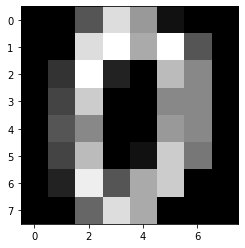

In [89]:
from matplotlib.pylab import subplots, cm
from sklearn import datasets
mnist = datasets.load_digits()
fig, ax = subplots()
ax.imshow(mnist.images[0],
          interpolation='nearest',
          cmap=cm.gray)

In [90]:
fig.savefig('fig-machine_learning/image_processing_001.png')

 The `cmap` keyword argument specifies the colormap as gray. The
`interpolation` keyword means that the resulting image from `imshow` does not
try to visually smooth out the data, which can be confusing when working at the
pixel level.  The other hand drawn digits are shown below in [Figure](#fig:image_processing_002).



<!-- dom:FIGURE: [fig-machine_learning/image_processing_001.png, width=200 frac=0.25] Image of a hand drawn number zero from the MNIST dataset.   <div id="fig:image_processing_001"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_001"></div>

<p>Image of a hand drawn number zero from the MNIST dataset.</p>
<img src="fig-machine_learning/image_processing_001.png" width=200>

<!-- end figure -->

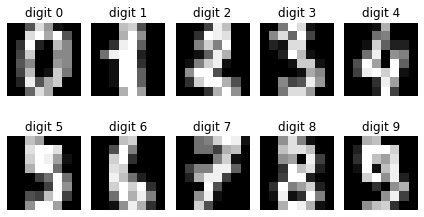

In [119]:
fig, axs = subplots(2,5, constrained_layout=False)
fig.tight_layout()
for i,(ax,j) in enumerate(zip(axs.flatten(),mnist.images)):
   _=ax.imshow(j,interpolation='nearest',cmap=cm.gray)
   _=ax.set_title('digit %d'%(i))
   _=ax.spines['top'].set_visible(False)
   _=ax.spines['bottom'].set_visible(False)
   _=ax.spines['left'].set_visible(False)
   _=ax.spines['right'].set_visible(False)
   _=ax.spines['top'].axis.set_ticks_position('none')
   _=ax.spines['bottom'].axis.set_ticks_position('none')
   _=ax.spines['left'].axis.set_ticks_position('none')
   _=ax.spines['right'].axis.set_ticks_position('none')
   _=ax.xaxis.set_visible(False)
   _=ax.yaxis.set_visible(False)

fig.tight_layout()
fig.savefig('fig-machine_learning/image_processing_002.png')

<!-- dom:FIGURE: [fig-machine_learning/image_processing_002.png, width=500 frac=0.65] Samples of the other hand drawn digits from MNIST.  <div id="fig:image_processing_002"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_002"></div>

<p>Samples of the other hand drawn digits from MNIST.</p>
<img src="fig-machine_learning/image_processing_002.png" width=500>

<!-- end figure -->


### Convolution

Convolution is an intensive calculation and it is the core of convolutional
neural networks. The purpose of convolution is to create alternative
representations of the input image that emphasize or demphasize certain
features represented by the *kernel*.  The convolution operation consists of a
kernel and an *input matrix*.  The convolution operation is a way of aligning
and comparing image data with the corresponding data in an image kernel.  You
can think of an image kernel as a template for a canonical feature that the
convolution operation will uncover.  To keep it simple suppose we have the
following `3x3` kernel matrix,

In [120]:
import numpy as np
kern = np.eye(3,dtype=np.int)
kern

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

 Using this kernel, we want to find anything in an input image that
looks like a diagonal line. Let's suppose we have the following input Numpy image

In [121]:
tmp = np.hstack([kern,kern*0])
x = np.vstack([tmp,tmp])
x

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

 Note that this image is just the kernel stacked into a larger Numpy
array. We want to see if the convolution can pull out the kernel that is
embedded in the image.  Of course, in a real application we would not know
whether or not the kernel is present in the image, but this example 
helps us understand the convolution operation step-by-step. There is a 
convolution function available in the `scipy` module.

In [122]:
from scipy.ndimage.filters import convolve
res = convolve(x,kern,mode='constant',cval=0)
res

array([[2, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0],
       [2, 0, 0, 1, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0]])

Each step of the convolution operation is represented in [Figure](#fig:image_processing_003).  The `kern` matrix (light blue square) is
overlaid upon the `x` matrix and the element-wise product is computed and
summed. Thus, the `0,0` array output corresponds to this operation applied to
the top-left 3x3 slice of the input, which results in `3`.  The convolution
operation is sensitive to boundary conditions. For this example, we have chosen
`mode=constant` and `cval=0` which means that the input image is bordered by
zeros when the kernel sweeps outside of the input image boundary. This is the
simplest option for managing the edge conditions and
`scipy.ndimage.filters.convolve` provides other practical alternatives. It also
common to normalize the output of the convolution operation by dividing by the
number of pixels in the kernel (i.e., `3` in this example).  Another way to
think about the convolution operation is as a matched filter that peaks when it
finds a compatible sub-feature. The final output of the convolution operation 
is shown in [Figure](#fig:image_processing_004). The values of the 
individual pixels are shown in color. Notice where the maximum values of the
output image are located on the diagonals.

<!-- dom:FIGURE: [fig-machine_learning/image_processing_003.png, width=500 frac=0.85] The convolution process that produces the `res` array. As shown in the sequence, the light blue `kern` array is slid around, overlaid, mutiplied, and summed upon the `x` array to generate the values of shown in the title. The output of the convolution is shown in [Figure](#fig:image_processing_004). <div id="fig:image_processing_003"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_003"></div>

<p>The convolution process that produces the <code>res</code> array. As shown in the sequence, the light blue <code>kern</code> array is slid around, overlaid, mutiplied, and summed upon the <code>x</code> array to generate the values of shown in the title. The output of the convolution is shown in [Figure](#fig:image_processing_004).</p>
<img src="fig-machine_learning/image_processing_003.png" width=500>

<!-- end figure -->


<!-- dom:FIGURE: [fig-machine_learning/image_processing_004.png, width=500 frac=0.55] The `res` array output of the convolution is shown in [Figure](#fig:image_processing_003). The values (in red) shown are the individual outputs of the convolution operation. The grayscale indicates relative magnitude of the shown values (darker is greater). <div id="fig:image_processing_004"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_004"></div>

<p>The <code>res</code> array output of the convolution is shown in [Figure](#fig:image_processing_003). The values (in red) shown are the individual outputs of the convolution operation. The grayscale indicates relative magnitude of the shown values (darker is greater).</p>
<img src="fig-machine_learning/image_processing_004.png" width=500>

<!-- end figure -->


However, the convolution operation is not a perfect detector and results in
nonzero values for other cases. For example, suppose the input image is a
forward-slash diagonal line. The step-by-step convolution with the kernel is
shown in [Figure](#fig:image_processing_005) with corresponding output in
[Figure](#fig:image_processing_006) that looks nothing like the kernel or the
input image.

<!-- dom:FIGURE: [fig-machine_learning/image_processing_005.png, width=500 frac=0.85] The input array is a forward slash diagonal. This sequence shows the step-by-step convolution operation. The output of this convolution is shown in [Figure](#fig:image_processing_006). <div id="fig:image_processing_005"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_005"></div>

<p>The input array is a forward slash diagonal. This sequence shows the step-by-step convolution operation. The output of this convolution is shown in [Figure](#fig:image_processing_006).</p>
<img src="fig-machine_learning/image_processing_005.png" width=500>

<!-- end figure -->


<!-- dom:FIGURE: [fig-machine_learning/image_processing_006.png, width=500 frac=0.35] The output of the convolution operation shown in [Figure](#fig:image_processing_005). Note that the output has nonzero elements where there is no match between the input image and the kernel. <div id="fig:image_processing_006"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_006"></div>

<p>The output of the convolution operation shown in [Figure](#fig:image_processing_005). Note that the output has nonzero elements where there is no match between the input image and the kernel.</p>
<img src="fig-machine_learning/image_processing_006.png" width=500>

<!-- end figure -->


We can use multiple kernels to explore an input image.
For example, suppose we have the input image shown on the left in [Figure](#fig:image_processing_007). The two kernels are shown in the upper row, with 
corresponding outputs on the bottom row. Each kernel is able to emphasize its 
particular feature but extraneous features appear in both outputs. We can have 
as many outputs as we have kernels but because each output image is as large as the 
input image, we need a way to reduce the size of this data.  

<!-- dom:FIGURE: [fig-machine_learning/image_processing_007.png, width=500 frac=0.85] Given two kernels (upper row) and the input image on the left, the output images are shown on the bottom row. Note that each kernel is able to emphasize its feature on the input composite image but other extraneous features appear in the outputs. <div id="fig:image_processing_007"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_007"></div>

<p>Given two kernels (upper row) and the input image on the left, the output images are shown on the bottom row. Note that each kernel is able to emphasize its feature on the input composite image but other extraneous features appear in the outputs.</p>
<img src="fig-machine_learning/image_processing_007.png" width=500>

<!-- end figure -->


### Maximum Pooling

To reduce the size of the output images, we can apply *maximum pooling*
to replace a tiled subset of the image with the maximum pixel value
in that particular subset. The following Python code illustrates maximum
pooling,

In [123]:
def max_pool(res,width=2,height=2):
    m,n = res.shape
    xi = [slice(i,i+width) for i in range(0,m,width)]
    yi = [slice(i,i+height) for i in range(0,n,height)]
    out = np.zeros((len(xi),len(yi)),dtype=res.dtype)
    for ni,i in enumerate(xi):
        for nj,j in enumerate(yi):
            out[ni,nj]= res[i,j].max()
    return out

**Programming Tip.**

The `slice` object provides programmatic array slicing. For
example, `x[0,3]=x[slice(0,3)]`. This means you can
separate the `slice` from the array, which makes it easier to manage.



 Pooling  reduces the dimensionality of the output of the convolution
and makes stacking convolutions together computationally feasible. [Figure](#fig:image_processing_008) shows the output of the `max_pool` function on
the indicated input images.

<!-- dom:FIGURE: [fig-machine_learning/image_processing_008.png, width=500 frac=0.65] The `max_pool` function reduces the size of the output images (left column) to the images on the right column. Note that the pool size is `2x2` so that the resulting pooled images are half the size of the original images in each dimension. <div id="fig:image_processing_008"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_008"></div>

<p>The <code>max_pool</code> function reduces the size of the output images (left column) to the images on the right column. Note that the pool size is <code>2x2</code> so that the resulting pooled images are half the size of the original images in each dimension.</p>
<img src="fig-machine_learning/image_processing_008.png" width=500>

<!-- end figure -->


### Rectified Linear Activation

Rectified Linear Activation Units (ReLUs) are neural network units that
implement the following activation function,

$$
r(x) = \begin{cases}
              x & \mbox{if }  x>0 \\
              0 & \mbox{otherwise }
          \end{cases}
$$

 To use this activation properly, the kernels in the convolutional
layer must be scaled to the $\lbrace -1,1 \rbrace$ range.   We 
can implement our own rectified linear activation function using the
following code,

In [96]:
def relu(x):
    'rectified linear activation function'
    out = np.zeros(x.shape,dtype=x.dtype)
    idx = x>=0
    out[idx]=x[idx]
    return out

Now that we understand the basic building blocks, let us investigate how the
operations fit together. To create some training image data, we use the
following function to create some random backwards and forwards slashed images
as shown in [Figure](#fig:image_processing_009).  As before, we have the
scaled kernels shown in [Figure](#fig:image_processing_010). We are going to
apply the convolution, max-pooling, and rectified linear activation function
sequence step-by-step and observe the outputs at each step.

In [97]:
def gen_rand_slash(m=6,n=6,direction='back'):
    '''generate random forward/backslash images. 
    Must have at least two pixels'''
    assert direction in ('back','forward') 
    assert n>=2 and m>=2
    import numpy as np
    import random
    out = -np.ones((m,n),dtype=float)
    i = random.randint(2,min(m,n))
    j = random.randint(-i,max(m,n)-1)
    t = np.diag([1,]*i,j)
    if direction == 'forward':
        t = np.flipud(t)
    try:
        assert t.sum().sum()>=2
        out[np.where(t)]=1
        return out
    except:
        return gen_rand_slash(m=m,n=n,direction=direction)

# create slash-images training data with classification id 1 or 0
training=[(gen_rand_slash(),1) for i in range(10)] + \
         [(gen_rand_slash(direction='forward'),0) for i in range(10)]

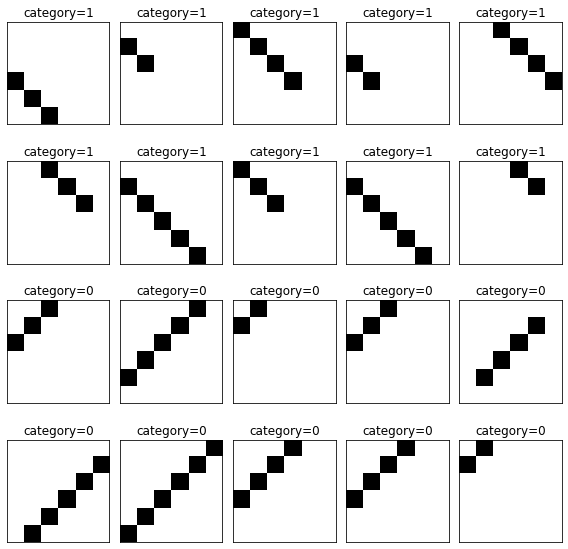

In [98]:
fig,axs=subplots(4,5,figsize=[8,8])
for ax,i in zip(axs.flatten(),training):
    _=ax.imshow(i[0],cmap='gray_r')
    _=ax.set_title(f'category={i[1]}')
    _=ax.tick_params(labelleft=False,left=False,labelbottom=False,bottom=False)

fig.tight_layout()
fig.savefig('fig-machine_learning/image_processing_009.png')

<!-- dom:FIGURE: [fig-machine_learning/image_processing_009.png, width=500 frac=0.65] The training data set for our convolutional neural network. The forward slash images are labelled category `0` and the backward slash images are category `1`. <div id="fig:image_processing_009"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_009"></div>

<p>The training data set for our convolutional neural network. The forward slash images are labelled category <code>0</code> and the backward slash images are category <code>1</code>.</p>
<img src="fig-machine_learning/image_processing_009.png" width=500>

<!-- end figure -->


<!-- dom:FIGURE: [fig-machine_learning/image_processing_010.png, width=500 frac=0.65] The two scaled feature kernels for the convolutional neural network. <div id="fig:image_processing_010"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_010"></div>

<p>The two scaled feature kernels for the convolutional neural network.</p>
<img src="fig-machine_learning/image_processing_010.png" width=500>

<!-- end figure -->


[Figure](#fig:image_processing_011) shows the output of convolving the
training data in [Figure](#fig:image_processing_009) with `kern1`, as shown on
the left panel of [Figure](#fig:image_processing_010). Note that 
the following code defines each of these kernels,

In [99]:
kern1 = (np.eye(3,dtype=np.int)*2-1)/9. # scale
kern2 = np.flipud(kern1)

The next operation is the activation function for the rectified linear unit
with output shown in [Figure](#fig:image_processing_012). Note that all of the
negative terms have been replaced by zeros. The next step is the maximum
pooling operation as shown in [Figure](#fig:image_processing_013). Notice that
the number of total pixels in the training data has reduced from thirty-six per
image to nine per image.   With these processed images, we have the inputs we
need for the final classification step.

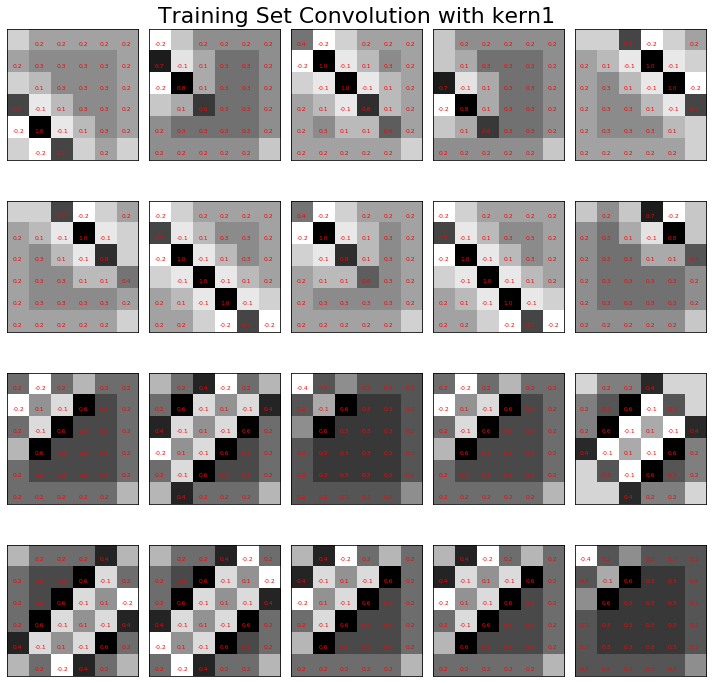

In [100]:
fig,axs=subplots(4,5,figsize=[10,10])
for ax,(i,cat) in zip(axs.flatten(),training):
    res1=convolve(i,kern1,mode='constant',cval=0)
    _= text_grid_array(res1,fontsize=6,fmt='%.1f',ax=ax)
    _= ax.tick_params(labelleft=False,left=False,labelbottom=False,bottom=False)

_=fig.suptitle('Training Set Convolution with kern1',fontsize=22)
fig.tight_layout()
fig.savefig('fig-machine_learning/image_processing_011.png')

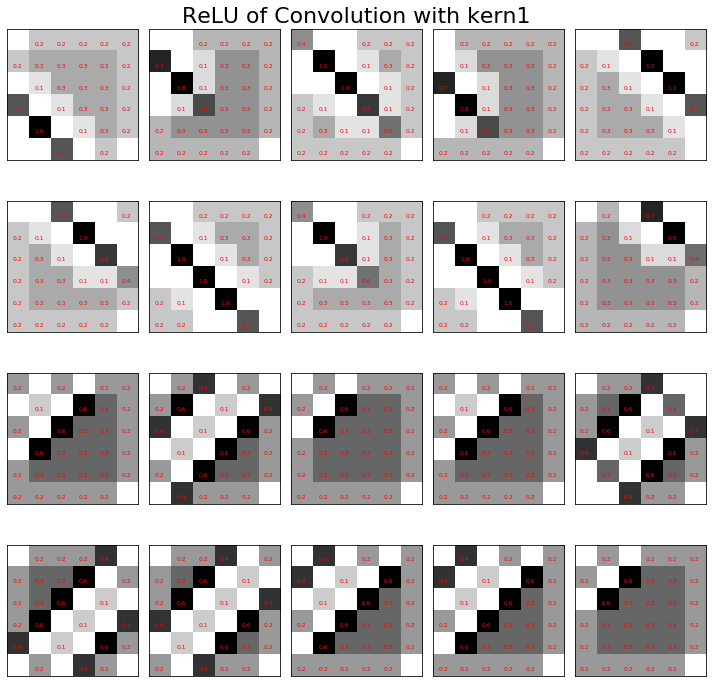

In [101]:
fig,axs=subplots(4,5,figsize=[10,10])

for ax,(i,cat) in zip(axs.flatten(),training):
    res1=convolve(i,kern1,mode='constant',cval=0)
    _=text_grid_array(relu(res1),fontsize=6,fmt='%.1f',ax=ax)
    _=ax.tick_params(labelleft=False,left=False,labelbottom=False,bottom=False)

_=fig.suptitle('ReLU of Convolution with kern1',fontsize=22)
fig.tight_layout()
fig.savefig('fig-machine_learning/image_processing_012.png')

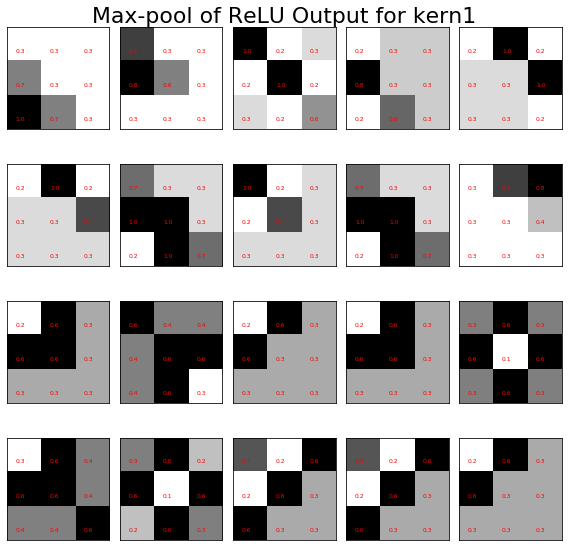

In [102]:
fig,axs=subplots(4,5,figsize=[8,8])
for ax,(i,cat) in zip(axs.flatten(),training):
    res1=convolve(i,kern1,mode='constant',cval=0)
    tmp= max_pool(relu(res1))
    _=text_grid_array(tmp,fontsize=6,fmt='%.1f',ax=ax)
    _=ax.tick_params(labelleft=False,left=False,labelbottom=False,bottom=False)

_=fig.suptitle('Max-pool of ReLU Output for kern1',fontsize=22)
fig.tight_layout()
fig.savefig('fig-machine_learning/image_processing_013.png')

<!-- dom:FIGURE: [fig-machine_learning/image_processing_011.png, width=500 frac=0.65] The output of convolving the training data in [Figure](#fig:image_processing_009) with `kern1`, as shown on the left panel of [Figure](#fig:image_processing_010). <div id="fig:image_processing_011"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_011"></div>

<p>The output of convolving the training data in [Figure](#fig:image_processing_009) with <code>kern1</code>, as shown on the left panel of [Figure](#fig:image_processing_010).</p>
<img src="fig-machine_learning/image_processing_011.png" width=500>

<!-- end figure -->


<!-- dom:FIGURE: [fig-machine_learning/image_processing_012.png, width=500 frac=0.65] The output of the rectified linear unit activation function with the input shown in [Figure](#fig:image_processing_011). <div id="fig:image_processing_012"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_012"></div>

<p>The output of the rectified linear unit activation function with the input shown in [Figure](#fig:image_processing_011).</p>
<img src="fig-machine_learning/image_processing_012.png" width=500>

<!-- end figure -->


<!-- dom:FIGURE: [fig-machine_learning/image_processing_013.png, width=500 frac=0.65] The output of maximum pooling operation with the input shown in [Figure](#fig:image_processing_012) for fixed image kernel `kern1`. <div id="fig:image_processing_013"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_013"></div>

<p>The output of maximum pooling operation with the input shown in [Figure](#fig:image_processing_012) for fixed image kernel <code>kern1</code>.</p>
<img src="fig-machine_learning/image_processing_013.png" width=500>

<!-- end figure -->


### Convolutional Neural Network Using Keras

Now that we have experimented with the individual operations using our own
Python code, we can construct the convolutional neural network using Keras. In
particular, we  use the Keras functional interface to define this neural
network because that makes it easy to unpack the operations at the individual
layers.

In [103]:
from keras import metrics
from keras.models import Model
from keras.layers.core import Dense, Activation, Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
from keras.utils import to_categorical

Note that the names of the modules are consistent with their 
operations.  We also need to tell `Keras` how to manage the input images,

In [104]:
K.set_image_data_format('channels_first') # image data format
inputs = Input(shape=(1,6,6)) # input data shape

  Now we can build the individual convolutional layers. Note the specification of
the activations at each layer and placement of the `inputs`.`

In [105]:
clayer = Conv2D(2,(3,3),padding='same',
            input_shape=(1,6,6),name='conv',
            use_bias=False,
            trainable=False)(inputs)

relu_layer= Activation('relu')(clayer)
maxpooling = MaxPooling2D(pool_size=(2,2),
                          name='maxpool')(relu_layer)
flatten = Flatten()(maxpooling)
softmax_layer = Dense(2, 
                      activation='softmax',
                      name='softmax')(flatten)
model = Model(inputs=inputs, outputs=softmax_layer)
# inject fixed kernels into convolutional layer
fixed_kernels = [np.dstack([kern1,kern2]).reshape(3,3,1,2)]
model.layers[1].set_weights(fixed_kernels)

W0827 13:30:23.762012 140166438127424 deprecation_wrapper.py:119] From /home/unpingco/.conda/envs/pypsml2E/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



 Observe that the functional interface means that each layer is
explicitly a function of the previous one. Note that `trainable=False` for the
convolutional layer because we want to inject our fixed kernels into it at the
end.  The `flatten` layer reshapes the data so that the entire processed image
at the point is fed into the `softmax_layer`, whose output is proportional to
the probability that the image belongs to either class. The `set_weights()`
function is where we inject our fixed kernels. These are not going to be
updated by the optimization algorithm because of the prior `trainable=False`
option.  With the topology of the neural network defined, we now have to choose
the optimization algorithm and pack all of this configuration into the model
with the `compile` step.

In [106]:
lr = 0.01 # learning rate
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy',
                       metrics.categorical_crossentropy])

 The `metrics` specification means that we want to training process to
keep track of those named items. Next, we generate some training data using our
`gen_rand_slash` function with the associated class of each image (`1` or `0`).
Most of this code is just shaping the tensors for Keras.  The final
`model.fit()` step is where the internal weights of the neural network are
adjusted according to the given inputs.

In [107]:
# generate some training data
ntrain = len(training)
t=np.dstack([training[i][0].T 
               for i in range(ntrain)]).T.reshape(ntrain,1,6,6)
y_binary=to_categorical(np.hstack([np.ones(ntrain//2),
                                   np.zeros(ntrain//2)]))
# fit the configured model
h=model.fit(t,y_binary,epochs=500,verbose=0)

With that completed, we can investigate the functional mapping of each layer 
with `K.function`. The following creates a mapping between the input layer and
the convolutional layer,

In [108]:
convFunction = K.function([inputs],[clayer])

 Now, we can feed the training data into this function as see the output of 
just the convolutional layer, which is shown,

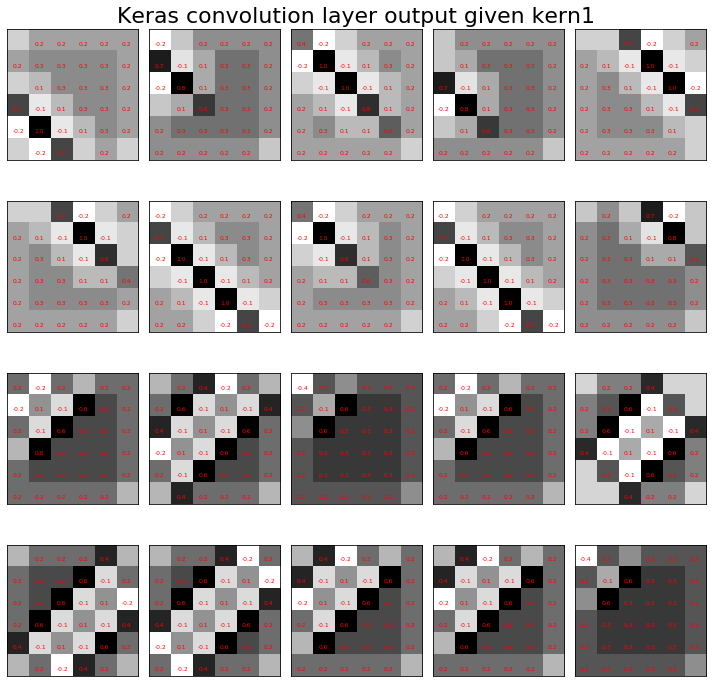

In [109]:
fig=draw_ndimage(convFunction([t])[0][:,0,:,:],4,5)
_=fig.suptitle('Keras convolution layer output given kern1',fontsize=22);
fig.tight_layout()
fig.savefig('fig-machine_learning/image_processing_015.png')

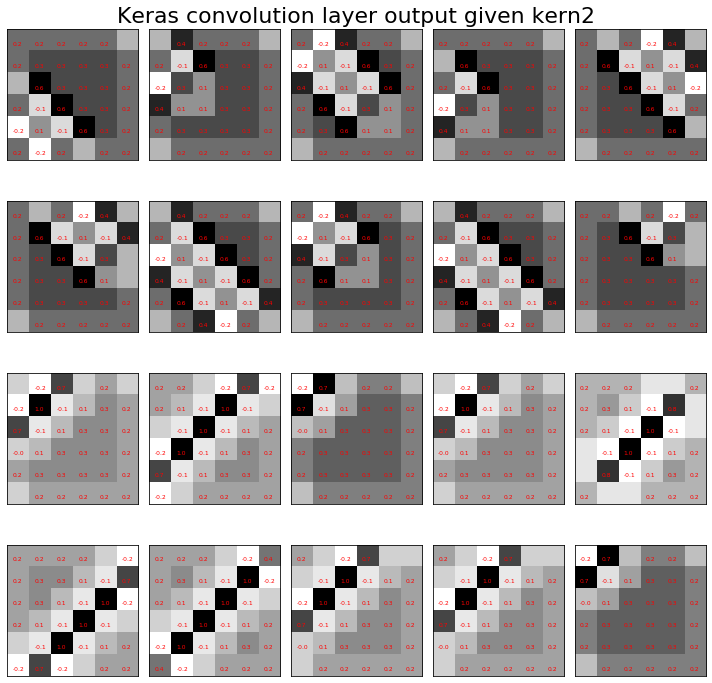

In [110]:
fig=draw_ndimage(convFunction([t])[0][:,1,:,:],4,5)
_=fig.suptitle('Keras convolution layer output given kern2',fontsize=22);
fig.tight_layout()
fig.savefig('fig-machine_learning/image_processing_016.png')

<!-- dom:FIGURE: [fig-machine_learning/image_processing_015.png, width=500 frac=0.75] Compare this to [Figure](#fig:image_processing_011). This shows our hand-tooled convolution is the same as that implemented by Keras.   <div id="fig:image_processing_015"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_015"></div>

<p>Compare this to [Figure](#fig:image_processing_011). This shows our hand-tooled convolution is the same as that implemented by Keras.</p>
<img src="fig-machine_learning/image_processing_015.png" width=500>

<!-- end figure -->


We can do this again for the pooling layer by creating another Keras function,

In [111]:
maxPoolingFunction = K.function([inputs],[maxpooling])

 whose output is shown in [Figure](#fig:image_processing_017). We can examine the 
final output of this network using the `predict` function,

In [112]:
fixed_kernels = model.predict(t)
fixed_kernels

array([[0.4350518 , 0.56494826],
       [0.24229054, 0.7577095 ],
       [0.14936452, 0.85063547],
       [0.48847622, 0.51152384],
       [0.27999252, 0.7200074 ],
       [0.37032166, 0.62967837],
       [0.06253155, 0.9374684 ],
       [0.16374767, 0.8362524 ],
       [0.06253155, 0.9374684 ],
       [0.42775342, 0.57224655],
       [0.82428503, 0.17571492],
       [0.9134076 , 0.0865923 ],
       [0.50833887, 0.49166116],
       [0.82428503, 0.17571492],
       [0.7137422 , 0.2862578 ],
       [0.6836652 , 0.31633478],
       [0.8407292 , 0.15927087],
       [0.7729743 , 0.22702564],
       [0.7729743 , 0.22702564],
       [0.50833887, 0.49166116]], dtype=float32)

 and we can see the weights given to each of the classes. Taking the 
maximum of these across the columns gives the following,

In [113]:
np.argmax(fixed_kernels,axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

 which means that our convolutional neural network with the fixed kernels 
did well predicting the classes of each of our input images. Recall that our model
configuration prevented our fixed kernels from updating in the training process. Thus, the
main work of model training was changing the weights of the final output layer. We can
re-do this exercise by removing this constraint and see how the network performs if
it is able to adaptively re-weight the kernel terms as part of training by changing the `trainable` 
keyword argument and then re-build and train the model, as shown next.

In [114]:
clayer = Conv2D(2,(3,3),padding='same',
            input_shape=(1,6,6),name='conv',
            use_bias=False)(inputs)

relu_layer= Activation('relu')(clayer)
maxpooling = MaxPooling2D(pool_size=(2,2),
                          name='maxpool')(relu_layer)
flatten = Flatten()(maxpooling)
softmax_layer = Dense(2, 
                      activation='softmax',
                      name='softmax')(flatten)
model = Model(inputs=inputs, outputs=softmax_layer)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd)
h=model.fit(t,y_binary,epochs=500,verbose=0)
new_kernels = model.predict(t)
new_kernels

array([[1.3517758e-02, 9.8648226e-01],
       [8.7332483e-03, 9.9126679e-01],
       [9.2126220e-06, 9.9999082e-01],
       [7.9193451e-03, 9.9208063e-01],
       [1.9740355e-03, 9.9802601e-01],
       [1.2133834e-03, 9.9878663e-01],
       [2.0620177e-05, 9.9997938e-01],
       [2.0275579e-03, 9.9797243e-01],
       [2.0620177e-05, 9.9997938e-01],
       [1.8704148e-02, 9.8129588e-01],
       [9.9372357e-01, 6.2764031e-03],
       [9.8774612e-01, 1.2253815e-02],
       [9.9268419e-01, 7.3158811e-03],
       [9.9372357e-01, 6.2764031e-03],
       [9.9093610e-01, 9.0638511e-03],
       [9.9482489e-01, 5.1751570e-03],
       [9.9963152e-01, 3.6841063e-04],
       [9.9949062e-01, 5.0930912e-04],
       [9.9949062e-01, 5.0930941e-04],
       [9.9268419e-01, 7.3158811e-03]], dtype=float32)

 with corresponding max output,

In [115]:
np.argmax(new_kernels,axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

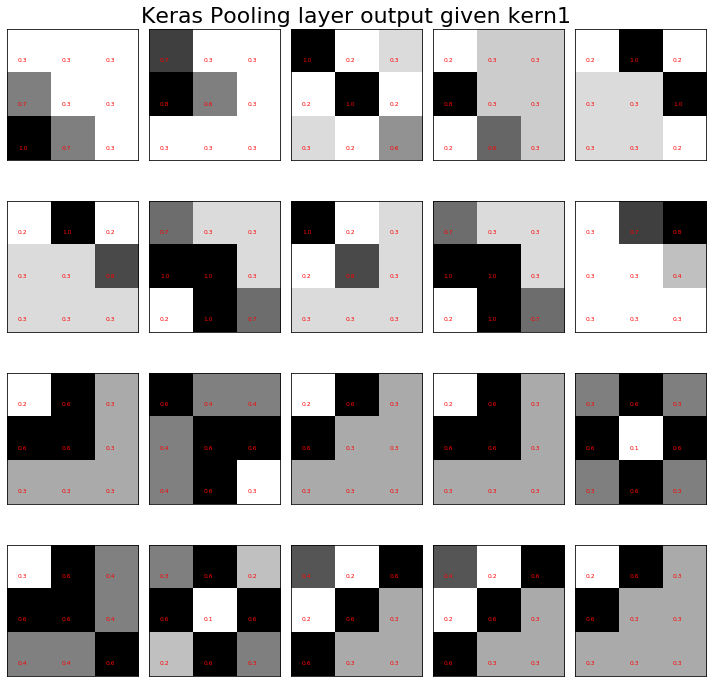

In [116]:
fig=draw_ndimage(maxPoolingFunction([t])[0][:,0,:,:],4,5)
_=fig.suptitle('Keras Pooling layer output given kern1',fontsize=22);
fig.tight_layout()
fig.savefig('fig-machine_learning/image_processing_017.png')

<!-- dom:FIGURE: [fig-machine_learning/image_processing_017.png, width=500 frac=0.75] Output of max-pooling layer for fixed kernel `kern1`. Compare this to [Figure](#fig:image_processing_013). This shows our hand-tooled implemention is equivalent to that by Keras. <div id="fig:image_processing_017"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_017"></div>

<p>Output of max-pooling layer for fixed kernel <code>kern1</code>. Compare this to [Figure](#fig:image_processing_013). This shows our hand-tooled implemention is equivalent to that by Keras.</p>
<img src="fig-machine_learning/image_processing_017.png" width=500>

<!-- end figure -->

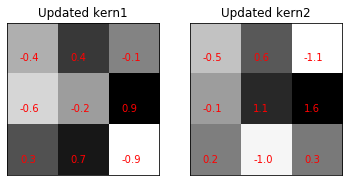

In [117]:
fig,axs=subplots(1,2,sharey=True,sharex=True)
text_grid_array(model.layers[1].get_weights()[0][:,:,0,0],fmt='%.1f',title='Updated kern1',ax=axs[0])
text_grid_array(model.layers[1].get_weights()[0][:,:,0,1],fmt='%.1f',title='Updated kern2',ax=axs[1])
for ax in axs:
    ax.tick_params(labelleft=False,left=False,labelbottom=False,bottom=False)

fig.savefig('fig-machine_learning/image_processing_018.png')

<!-- dom:FIGURE: [fig-machine_learning/image_processing_018.png, width=500 frac=0.65] Kernels updated during the training process. Compare to [Figure](#fig:image_processing_010). <div id="fig:image_processing_018"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_018"></div>

<p>Kernels updated during the training process. Compare to [Figure](#fig:image_processing_010).</p>
<img src="fig-machine_learning/image_processing_018.png" width=500>

<!-- end figure -->


 The newly updated kernels are shown in  [Figure](#fig:image_processing_018). Note how different these are from the original
fixed kernels. We can see the change in the respective predictions in [Figure](#fig:image_processing_019). Thus, the benefit of updating the kernels in the
training process is to improve the accuracy overall, but at the cost of
interpretability of the kernels themselves.  Nonetheless, it is seldom the case
that the kernels are known ahead of time, as in our artificial example here, so
in practice, there may be nothing to really interpet anyway. Nonetheless, for other
problems where there is a target feature in the data for which good a-priori
exemplars exist that could serve a kernels, then priming these kernels early in training
may help to tune into those target features, especially if they are rare in the training 
data.

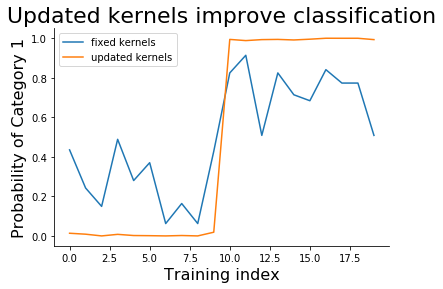

In [118]:
fig,ax=subplots()
_=ax.plot(fixed_kernels[:,0],label='fixed kernels')
_=ax.plot(new_kernels[:,0],label='updated kernels')
_=ax.set_xlabel('Training index',fontsize=16)
_=ax.set_ylabel('Probability of Category 1',fontsize=16)
_=ax.spines['top'].set_visible(False)
_=ax.spines['right'].set_visible(False)
_=ax.legend()
_=ax.set_title('Updated kernels improve classification',fontsize=22)
fig.savefig('fig-machine_learning/image_processing_019.png')

<!-- dom:FIGURE: [fig-machine_learning/image_processing_019.png, width=500 frac=0.65] Recall that the second half of the training set was classified as category `1`. The updated kernels provide a wider margin for classification  than our fixed kernels, even though the ultimate performance is very similar between them. <div id="fig:image_processing_019"></div> -->
<!-- begin figure -->
<div id="fig:image_processing_019"></div>

<p>Recall that the second half of the training set was classified as category <code>1</code>. The updated kernels provide a wider margin for classification  than our fixed kernels, even though the ultimate performance is very similar between them.</p>
<img src="fig-machine_learning/image_processing_019.png" width=500>

<!-- end figure -->